# 🏥 Analyzing Health and Poverty Data Across U.S. Counties (2022)

## 🅿️2️⃣ Project Part 2 - Analysis

- Part 1 for Reference - Data Description & Manipulation  [🔗 here](https://drive.google.com/file/d/1i_iRRPJ9NiVRdcf2OwAXoZuSNqFX13a2/view?usp=drive_link)
- Files required to run code [🔗 here](https://drive.google.com/drive/folders/1V3125F4iECq639qjbQvtiIQ2AUccKxBF?usp=sharing)

## 👥 Team Members  
- **Shreya Gupta** (*gshrey*)  
- **Vaishnavi Venkataraghavan** (*vaishven*)  
- **James Gair** (*jgair*)  

## 📂 Data Sources  
- 🏥 1. **CDC PLACES Health Data**  
- 📈 2. **U.S. Census Bureau ACS 5-Year Estimates**   

## ❓ Research Questions  
1. **How does the relationship between poverty rates and health outcomes vary across U.S. counties and do high-poverty areas experience significantly worse health outcomes compared to wealthier counties?**  

2. **What health risk behaviors are most prevalent in counties with higher poverty rates and do these behaviors correlate with disease prevalence?**

3. **How do poverty rates correlate with health disparities among people of color across different states?**  

### ⚙️ Initial Setup

We will repeat some of the initial setup from Project Part 1 in this section.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np

In [2]:
# Import the warnings module 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Set Pandas display options to format floating-point numbers with 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Read the csv file 
health_df = pd.read_csv("PLACES.csv")

In [4]:
health_df["LocationID"] = health_df["LocationID"].astype("object")

In [5]:
# Calculate the total number of patients based on the Data_Value and TotalPopulation
health_df['TotalPatients'] = (
    health_df['Data_Value'] * health_df['TotalPopulation'] / 100
).astype('int64')  # Convert the result to 'int64' type

# Calculate the total number of patients aged 18 and above based on the Data_Value and TotalPop18plus
health_df['TotalPatients18plus'] = (
    health_df['Data_Value'] * health_df['TotalPop18plus'] / 100
).astype('int64')  # Convert the result to 'int64' type

In [6]:
# Cencus ACS Poverty/Income Data Merge

#  Load the CSV file
csv_path = "acs_poverty_md.csv"  
mapping = pd.read_csv(csv_path)  

# Extract the column names for the API request
columns = mapping["Column Name"].tolist()

# Construct the API URL
base_url = "https://api.census.gov/data/2022/acs/acs5/subject"
params = ",".join(columns)
query_url = f"{base_url}?get={params}&for=county:*"

# Call the API
response = requests.get(query_url)
if response.status_code != 200:
    print(f"Error: {response.status_code}, {response.text}")
else:  
    data = response.json()
    
    # Convert response to DataFrame
    census_df = pd.DataFrame(data[1:], columns=data[0])
    
    # Create a mapping from "Column Name" to "Label"
    column_mapping = dict(zip(mapping["Column Name"], mapping["Label"]))
    
    # Rename columns in census_df
    census_df.rename(columns=column_mapping, inplace=True)
    
    # Replace -999999999 values with 0
    census_df.replace("-999999999", "0", inplace=True)
    census_df.replace("-888888888", "0", inplace=True)
    census_df.replace("-666666666.0", "0", inplace=True)
    
    # Save to CSV
    census_df.to_csv("poverty_census_data.csv", index=False)
    print("Data saved as poverty_census_data.csv")

Data saved as poverty_census_data.csv


In [7]:
# Split 'Geographic Area Name' into State and County
census_df[['County', 'State']] = census_df['Geographic Area Name'].str.split(',', expand=True)

# Strip extra spaces
census_df['County'] = census_df['County'].str.strip().str.split().str[0]
census_df['State'] = census_df['State'].str.strip()

#Display the result
census_df.head()

,Geography,Geographic Area Name,Total,T_ Male,T_ Female,T_ African American,T_ American Indian/Alaska Native,T_ Asian,T_ Hawaiian/ Pacific Islander,T_ Two or more races,...,T_Households,Households<$10k,Households>$200k,Median income,Mean income,BP_ Total%,state,county,County,State
0,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,22308,4.4,7.4,68315,90372,11.4,01,001,Autauga,Alabama
1,0500000US01003,"Baldwin County, Alabama",229539,111484,118055,18560,745,2046,31,10408,...,90802,4.5,9.1,71039,96027,10.2,01,003,Baldwin,Alabama
2,0500000US01005,"Barbour County, Alabama",21851,10122,11729,10134,23,122,3,503,...,9016,10.2,3.8,39712,60128,24.2,01,005,Barbour,Alabama
3,0500000US01007,"Bibb County, Alabama",20836,10607,10229,3856,21,69,0,553,...,7216,7.6,3.5,50669,65131,20.6,01,007,Bibb,Alabama
4,0500000US01009,"Blount County, Alabama",58399,29527,28872,608,227,100,117,2083,...,21626,6.7,4.9,57440,75954,14.2,01,009,Blount,Alabama


In [8]:
# Extract the list of column labels from the 'Label' column in the mapping DataFrame.
label = mapping["Label"].tolist()

# Iterate through each column name in the extracted label list.
for column in label:
    # Check if the column is one of the specified columns that should be converted to float64.
    if column in ['Households<$10k', 'Households>$200k', 'BP_ Total%', 'BP_ African American%', 'BP_ American Indian/ Alaska Native%', 'BP_ Asian%', 'BP_ Hawaiian/ Pacific Islander%', 'BP_ Two or more races%', 'BP_ Other race%', 'BP_ Hispanic or Latino%', 'BP_ White%']:
        census_df[column] = census_df[column].astype('float64')  # Convert column to float64 type.
    
    # If the column is not 'Geography' or 'Geographic Area Name', convert it to int64.
    elif column not in ['Geography', 'Geographic Area Name']:
        census_df[column] = census_df[column].astype('int64')  # Convert column to int64 type.

In [9]:
# Merge datasets on State and County/LocationName
combined_df = census_df.merge(health_df, left_on=["State", "County"], right_on=["StateDesc", "LocationName"], how="inner")

# Display merged dataset
combined_df.head()

,Geography,Geographic Area Name,Total,T_ Male,T_ Female,T_ African American,T_ American Indian/Alaska Native,T_ Asian,T_ Hawaiian/ Pacific Islander,T_ Two or more races,...,Data_Value_Type,Data_Value,TotalPopulation,TotalPop18plus,LocationID,CategoryID,MeasureId,Short_Question_Text,TotalPatients,TotalPatients18plus
0,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,Age-adjusted prevalence,14.10,59759,45878,1001,DISABLT,COGNITION,Cognitive Disability,8426,6468
1,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,Age-adjusted prevalence,31.10,59759,45878,1001,DISABLT,DISABILITY,Any Disability,18585,14268
2,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,Age-adjusted prevalence,37.70,59759,45878,1001,RISKBEH,SLEEP,Short Sleep Duration,22529,17296
3,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,Age-adjusted prevalence,6.40,59759,45878,1001,DISABLT,HEARING,Hearing Disability,3824,2936
4,0500000US01001,"Autauga County, Alabama",58291,28287,30004,11358,59,658,0,2473,...,Age-adjusted prevalence,12.00,59759,45878,1001,HLTHOUT,TEETHLOST,All Teeth Lost,7171,5505


Some columns in the dataset serve as ID columns, and others are duplicated after merging the data. These columns can be removed to streamline the dataset and avoid redundancy.
`Data_Value` and `Short_Question_Text` have pretty ambiguous names. We will also rename these columns for clarity and ease of use.

In [10]:
# Define a list of columns to exclude from the 'combined_df' DataFrame.
exclude_columns = ['Geography', 'Geographic Area Name', 'state', 'county', 'Year', 'Data_Value_Unit', 'Data_Value_Type', 'LocationID', 'CategoryID', 'MeasureId', 'StateDesc', 'LocationName', 'Measure']

# Drop the specified columns from 'combined_df' and create a new DataFrame 'combined_df_dropped'.
combined_df_dropped = combined_df.drop(exclude_columns, axis=1)

In [11]:
# Rename columns in the 'combined_df_dropped' dataFrame for clarity.
combined_df_clean = combined_df_dropped.rename(columns={'Data_Value': 'Pop_Percent', 'Short_Question_Text': 'Health_Measure'})

⚠️ ***Note:*** **Comparative Analysis** and **Multivariate Analysis** will be incorporated throughout all subdivisions (Descriptive, Inferential, and Graphical)

## 1️⃣ Research Question 1:  

### How does the relationship between poverty rates and health outcomes vary across U.S. counties and do high-poverty areas experience significantly worse health outcomes compared to wealthier counties?

## 📝 Descriptive Statistics  

In [12]:
# Save the cleaned combined dataframe to a CSV file without including the index column
combined_df_clean.to_csv("complete_data.csv", index=False) 

# Create a copy of the cleaned combined dataframe to preserve the original data
df = combined_df_clean.copy()

In [13]:
def pivot_disease(df):
    # Filter data for Health Outcomes category
    health_outcomes_df = df[df["Category"] == "Health Outcomes"]

    # Pivot the data so each Health Measure becomes a column with Pop_Percent as values
    pivot_df = health_outcomes_df.pivot_table(index=["County", "State", "BP_ Total%"], 
                                            columns="Health_Measure", 
                                            values="Pop_Percent").reset_index()

    return pivot_df

pivot_disease(df).describe()

Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,2942.00,2942.00,2942.00,2942.00,2942.00,2942.00,2942.00,2942.00,2942.00,2880.00,2880.00,2942.00,2942.00
mean,14.39,16.24,26.21,7.58,7.05,6.50,10.86,24.35,11.15,32.75,30.67,38.05,3.44
std,5.97,5.89,2.92,1.79,0.55,0.90,0.94,3.45,2.29,4.73,2.30,4.53,0.68
min,1.60,3.70,16.20,3.30,4.60,4.10,7.30,13.80,6.00,20.90,21.30,18.60,2.00
25%,10.10,12.00,24.12,6.30,6.80,5.90,10.20,22.00,9.50,29.20,29.00,35.50,3.00
50%,13.50,15.50,25.90,7.40,7.20,6.40,10.80,24.30,10.80,32.10,30.95,38.50,3.30
75%,17.50,19.80,28.20,8.70,7.40,7.10,11.50,26.60,12.57,35.60,32.50,41.00,3.80
max,52.20,44.60,36.60,16.30,8.20,11.50,15.60,35.70,21.50,52.70,36.30,53.00,8.00


### 🔍 Inference

1. **Most Common Conditions** 

- **Obesity** (Mean: 38.05%), **High Blood Pressure** (32.75%), and **High Cholesterol** (30.67%) are the most prevalent conditions.  
- **Stroke** (Mean: 3.44%) is the least common. However, this is in the context of *our dataset*, which only presents some of the most common health outcomes. Therefore, while stroke appears rare here, it is among the *most common* conditions reported in the dataset.  

2. **Variations in Data** 

- Obesity (18.6% – 53%) and Diabetes (6% – 21.5%) show large differences across counties.  
  - Obesity (Std: 4.53) and Diabetes (Std: 2.29) fluctuate significantly across counties.  
- Cancer (4.6% – 8.2%) and Stroke (2% – 8%) are more stable.  
  - Cancer (Std: 0.55) and Stroke (Std: 0.68) are more consistent across counties.  

3. **Dental Care is Concerning**  

- **All Teeth Lost** has the highest interquartile range (IQR) (19.8 - 12 = 7.8), meaning it varies the most across U.S. counties.  

4. **Wealth Disparity is *also* Concerning**  

- BP _Total% (Poverty %) also has a large IQR, indicating substantial economic disparities.  

#### 🔬 Next Steps  
To deepen our analysis, we will now focus on the **most impoverished**, **least impoverished**, and **moderate-income** states to better understand these disparities. 

In [14]:
# Calculate mean BP_ Total% per state
state_poverty = df.groupby("State", as_index=False)["BP_ Total%"].mean()

# Get threshold values
most_poor_bp = state_poverty["BP_ Total%"].max()
least_poor_bp = state_poverty["BP_ Total%"].min()
mean_poor_bp = state_poverty["BP_ Total%"].mean()

# Find the state with BP_Total% closest to the median
closest_median_state = state_poverty.loc[(state_poverty["BP_ Total%"] - mean_poor_bp).abs().nsmallest(1).index, "State"].values[0]

most_poor_df = df[df["State"].isin(state_poverty[state_poverty["BP_ Total%"] == most_poor_bp]["State"])]
least_poor_df = df[df["State"].isin(state_poverty[state_poverty["BP_ Total%"] == least_poor_bp]["State"])]
mean_poor_df = df[df["State"] == closest_median_state]

print("Most Poor State:\n", most_poor_df["State"].unique())
print("Least Poor State:\n", least_poor_df["State"].unique())
print("Mean Poor State:\n", mean_poor_df["State"].unique())

Most Poor State:
 ['Mississippi']
Least Poor State:
 ['New Hampshire']
Mean Poor State:
 ['Montana']


### 🏛️ Key States for Analysis

- **Most Impoverished State:** *Mississippi*
- **Least Impoverished State:** *New Hampshire*
- **Average (Mean) Poverty State:** *Montana*

**Why Use the Mean?**

While the median is typically a better indicator of central tendency, we chose to use the **mean percent below the poverty line** to **highlight outliers**. This approach ensures that we account for the **richest of the rich** and the **poorest of the poor**, rather than smoothing out the data.

Our findings align with the data provided by the [U.S. Census Bureau](https://www.census.gov/topics/income-poverty/poverty.html) as well as this [Wikipedia article](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate).  

#### 🔬 Next Steps

Let's perform a **descriptive analysis** on these states to further explore health and poverty disparities!


In [15]:
pivot_disease(most_poor_df).describe()

Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00
mean,21.99,22.75,29.98,8.97,6.24,7.31,10.81,21.51,14.53,43.26,31.39,43.74,4.54
std,5.87,5.97,1.59,1.17,0.64,0.62,0.65,1.72,2.31,4.26,0.89,3.80,0.82
min,9.50,8.40,25.10,5.50,5.00,5.30,9.60,18.30,10.60,34.90,28.70,34.70,2.90
25%,18.20,19.20,29.00,8.30,5.90,6.90,10.40,20.20,12.80,40.40,30.90,41.40,3.90
50%,21.50,22.70,30.10,8.90,6.40,7.30,10.80,21.70,14.30,42.80,31.40,43.60,4.40
75%,25.70,25.60,31.00,9.60,6.70,7.70,11.10,22.70,16.00,45.70,32.00,45.80,5.00
max,37.00,39.00,33.60,11.60,7.50,8.70,12.30,24.80,20.10,52.70,33.50,53.00,6.70


In [16]:
pivot_disease(mean_poor_df).describe()

Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00
mean,13.55,14.78,26.06,6.60,7.20,5.94,11.37,25.07,8.39,28.28,25.90,33.53,3.26
std,6.20,4.97,1.85,1.30,0.22,0.78,0.92,1.27,1.48,2.28,0.97,3.41,0.66
min,2.40,7.30,22.60,4.70,6.40,4.90,10.10,22.70,6.60,24.60,24.10,23.70,2.50
25%,9.70,11.88,24.70,5.88,7.10,5.40,10.90,24.27,7.60,26.98,25.25,31.90,2.88
50%,12.10,12.85,25.80,6.25,7.25,5.75,11.15,25.05,8.05,27.95,25.90,33.60,3.10
75%,16.90,17.68,27.12,6.93,7.30,6.20,11.62,25.60,8.65,29.55,26.32,35.45,3.40
max,31.50,27.10,31.20,10.70,7.60,8.50,14.80,28.60,14.20,34.80,28.60,41.40,5.80


In [17]:
pivot_disease(least_poor_df).describe()

Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,8.68,9.86,24.60,6.06,7.58,5.54,11.58,25.90,8.07,26.45,27.65,31.21,2.67
std,2.12,2.08,1.10,0.74,0.20,0.41,0.23,1.06,0.69,1.35,1.68,2.17,0.23
min,4.80,7.60,23.10,4.80,7.10,4.90,11.30,23.50,7.00,24.40,24.80,28.50,2.30
25%,7.40,8.18,23.88,5.58,7.53,5.35,11.40,25.50,7.62,25.82,26.55,29.93,2.60
50%,8.80,9.85,24.45,6.25,7.60,5.55,11.55,26.20,8.00,26.10,27.85,30.95,2.70
75%,9.70,10.52,25.62,6.57,7.67,5.88,11.67,26.62,8.47,27.02,28.48,32.15,2.80
max,11.70,14.30,26.10,7.00,7.80,6.10,12.00,27.00,9.10,28.60,30.40,35.90,3.00


### 🔍 **Inference**

1. **Dental Health is a Major Issue in Poorer States:**  

- All Teeth Lost is highest in Mississippi (22.75%), well above the national average (16.24%).  
- Montana (14.78%) and New Hampshire (9.86%) show a clear decline in prevalence as wealth increases.  

2. **Chronic Diseases/Conditions are More Severe in Poorer States:**  

- Obesity (Mississippi: 43.74%) is significantly higher than Montana (33.53%) and New Hampshire (31.21%). The national average is 38.05%.  
- High Blood Pressure and Diabetes follow a similar trend—highest in Mississippi, lowest in New Hampshire.    

3. **Mental Health Trends Differ by State:**  

- Depression rates are highest in wealthier states like New Hampshire (25.90%) and Montana (25.07%).  
- Mississippi has the lowest depression rate (21.51%)

Whether the health outcomes are *significant* will be checked with statistical tests further along the line.

## 🔬 Inferential Statistics

#### 📊❓What's the best statistical test for our questions?

**Ordinary Least Squares (OLS) regression** is the **most suitable statistical method** for analyzing this dataset because it primarily consists of **numerical variables of interest**, such as **poverty rate, health outcomes, health risk behaviours, etc.**. OLS allows us to **quantify the strength and direction of relationships** between these continuous variables, making it ideal for understanding how changes in one factor (e.g., poverty rate) impact another (e.g., physical inactivity or smoking prevalence). 

In contrast, **ANOVA** is typically used to compare means across **categorical groups**, which is less relevant here since our variables are not grouped into predefined categories. 

Similarly, the **Chi-Squared test** is best suited for **assessing relationships between categorical variables**, such as whether smoking status (yes/no) differs by income bracket, rather than analyzing continuous trends. Because our dataset consists mainly of **continuous numerical measures**, OLS regression provides a more precise and interpretable analysis of **how health behaviors scale with economic factors across different counties**.

#### **Null Hypothesis (H₀):**  
There is **no association** between **poverty levels** (`BP_ Total%`) and the prevalence of **health outcomes** (Obesity, Cancer, All Teeth Lost, etc.) in different counties.

#### **Alternative Hypothesis (H₁):**  
There **is an association** between **poverty levels** (`BP_ Total%`) and the prevalence of **health outcomes** (Obesity, Cancer, All Teeth Lost, etc.) in different counties.

In [18]:
import pandas as pd
import statsmodels.api as sm

# Filter dataset for only Health Outcomes
health_outcomes = df[df["Category"] == "Health Outcomes"]["Health_Measure"].unique()

# List to store regression results
results_list = []

# Loop through each health outcome and run OLS regression
for outcome in health_outcomes:
    subset_df = df[df["Health_Measure"] == outcome]

    # Independent variable: Poverty Rate
    X = subset_df["BP_ Total%"]
    y = subset_df["Pop_Percent"]

    # Add constant (intercept)
    X = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    # Store results in a list
    results_list.append({
        "Health Outcome": outcome,
        "R²": round(model.rsquared, 3),
        "P-Value": f"{model.pvalues['BP_ Total%']}",  # Display full precision
        "Coefficient": round(model.params["BP_ Total%"], 3)
    })

# Convert results to a DataFrame and sort by R²
results_df = pd.DataFrame(results_list).sort_values(by="R²", ascending=False)

# Display the final structured results
print("OLS Regression Results: Poverty vs Health Outcomes")
results_df


OLS Regression Results: Poverty vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
5,Stroke,0.72,0.0,0.10
7,Coronary Heart Disease,0.57,0.0,0.12
3,Diabetes,0.56,0.0,0.29
0,All Teeth Lost,0.54,0.0,0.73
9,High Blood Pressure,0.50,0.0,0.56
2,COPD,0.47,0.0,0.21
11,Arthritis,0.35,1.4564589169210874e-281,0.29
6,Obesity,0.27,3.003027219287969e-199,0.39
1,Current Asthma,0.23,1.5666039455296612e-166,0.07
8,High Cholesterol,0.16,4.365178948531259e-114,0.15


Before we get to our **inferences**, there is one glaring observation we must address:

#### **🔍 Why are the P-Values so low?**  

Our **p-values are extremely small**, which might seem unusual, but given the **large dataset size**, this is actually expected. 

1. **Large Sample Size Drives P-Values Down**  
   - Our dataset includes **120,443 rows from CDC PLACES** and **3,221 rows from Census ACS**, meaning we’re working with thousands of observations.  
- Larger sample sizes make statistical tests more sensitive, meaning even very weak relationships can become statistically significant.  
- In OLS regression, **p-values measure how likely it is that the coefficient is zero**. With a large dataset, even small correlations become statistically significant.  
- **Example:**  
  - If we only had 30 data points, a correlation needs to be strong to be considered significant.  
  - But with 100,000+ data points, even a weak effect is unlikely due to random chance, driving the p-value extremely low.  


2. **P-Values Are Not Effect Sizes**  
  - Just because a p-value is very small does **not** mean the effect is large or important.  
- The coefficient tells us the real impact, not the p-value.  
- **Example:**  
  - Obesity Coefficient = 0.39 (Moderate effect)  
  - P-value = 3.00e-199 (Extremely small, but doesn't mean effect size is huge)  


3. **R² for Model Fit Evaluation**  
   - Since **all variables are significant**, we should focus on **R²**, which accounts for sample size and complexity. 


#### **🔍 So, Do We Reject the Null Hypothesis?**  

Yes, **we still reject the null hypothesis** because:  

1. **The p-values are still valid despite being extremely small**  
    - A **low p-value (< 0.05)** means there is **strong evidence against the null hypothesis** (which states that poverty and health outcomes have no relationship).  
    - Even though the dataset is large, the results still indicate **a statistically significant relationship** between poverty and various health outcomes.  

2. **The effect sizes (coefficients) are meaningful**  
    - The coefficients tell us **how much** poverty influences each health outcome.  
    - For example, **Obesity (0.39)** and **Diabetes (0.29)** suggest a real, measurable increase with rising poverty rates.  

3. **We are measuring population-level effects, not just a small sample**  
    - Since we are working with **large, national datasets**, our results **represent real-world patterns** rather than just random variation in a small dataset.  
    - The null hypothesis assumes there is **no association**, but given the large dataset, we are detecting **consistent trends across thousands of counties**.  

#### Now that we have **rejected** the null hypothesis across all health outcomes, we can assume our results are statistically significant. Let us take a look at our inferences.

### **🔍 Inference**  

1. **Strongest Correlation Between Poverty and Stroke Rates**  
   - Stroke has the highest R² (0.72), meaning 72% of its variation is explained by poverty rate.  
   - Coefficient (0.10) suggests that for every 1% increase in poverty rate, stroke prevalence increases by 0.10%.  
   - This indicates a **strong link between economic hardship and stroke risk**.

2. **Poverty Has a High Impact on Chronic Diseases**  
   - Coronary Heart Disease (R² = 0.57), Diabetes (0.56), and High Blood Pressure (0.50) all show strong positive correlations with poverty.   
   - The high coefficients (Diabetes = 0.29, Blood Pressure = 0.56)** suggest that poverty rate plays a major role in the prevalence of these diseases.  

3. **Oral Health is Strongly Tied to Poverty**  
   - All Teeth Lost has R² = 0.54, with the highest coefficient (0.73).   

4. **Obesity is Moderately Correlated with Poverty**  
   - R² = 0.27 suggests that poverty explains 27% of obesity variation, which is still significant.  
   - Coefficient (0.39) means higher poverty rates lead to increased obesity.   

5. **Poverty Has Less Impact on Cancer and Depression**  
   - Cancer (R² = 0.16, Coefficient = -0.04) has a very weak relationship with poverty.
   - Depression (R² = 0.05) has the lowest correlation, meaning poverty alone does not explain much of its variation.


#### Although OLS is the best approach for our data, let's conduct some **ANOVA analysis** by segmenting **poverty levels** into **High**, **Medium**, and **Low**

In [19]:
import scipy.stats as stats

# Define poverty level categories (Low, Medium, High) using quantiles
df["Poverty_Level"] = pd.qcut(df["BP_ Total%"], q=3, labels=["Low", "Medium", "High"])

# Get a list of all Health Outcomes
health_outcomes = df[df["Category"] == "Health Outcomes"]["Health_Measure"].unique()

# Store results in a list
anova_results = []

# Loop through each health outcome and perform ANOVA
for outcome in health_outcomes:
    subset_df = df[df["Health_Measure"] == outcome]

    # Group health outcome values by poverty level
    low_poverty = subset_df[subset_df["Poverty_Level"] == "Low"]["Pop_Percent"]
    medium_poverty = subset_df[subset_df["Poverty_Level"] == "Medium"]["Pop_Percent"]
    high_poverty = subset_df[subset_df["Poverty_Level"] == "High"]["Pop_Percent"]

    # Skip if any group has fewer than 2 values (avoids errors)
    if len(low_poverty) < 2 or len(medium_poverty) < 2 or len(high_poverty) < 2:
        continue

    # Run ANOVA test
    f_stat, p_value = stats.f_oneway(low_poverty, medium_poverty, high_poverty)

    # Store results
    anova_results.append({
        "Health Outcome": outcome,
        "F-Statistic": round(f_stat, 3),
        "P-Value": f"{p_value:.10f}"  # Show full precision
    })

# Convert results to a DataFrame and sort by F-statistic
anova_df = pd.DataFrame(anova_results).sort_values(by="F-Statistic", ascending=False)

# Display results
print("ANOVA Results: Health Outcomes vs Poverty Levels")
anova_df


ANOVA Results: Health Outcomes vs Poverty Levels


,Health Outcome,F-Statistic,P-Value
5,Stroke,1619.59,0.0000000000
7,Coronary Heart Disease,1194.28,0.0000000000
3,Diabetes,1176.48,0.0000000000
9,High Blood Pressure,1105.12,0.0000000000
0,All Teeth Lost,1105.03,0.0000000000
2,COPD,1004.79,0.0000000000
11,Arthritis,693.80,0.0000000000
6,Obesity,388.44,0.0000000000
1,Current Asthma,324.44,0.0000000000
8,High Cholesterol,312.96,0.0000000000


Our reasoning for **rejecting** the null hypothesis is the same as our previous analysis.

### **🔍 Inference**  

1. **Stroke, Heart Disease, and Diabetes Are the Most Affected by Poverty**  
   - Stroke (F = 1619.59) has the highest F-statistic, meaning the difference in stroke rates across poverty levels is the most pronounced.  
   - Coronary Heart Disease (F = 1194.28) and Diabetes (F = 1176.48) follow closely, indicating that cardiovascular and metabolic diseases are highly affected by economic status.   

2. **Chronic Conditions Like High Blood Pressure & COPD Show Strong Associations**  
   - High Blood Pressure (F = 1105.12), COPD (F = 1004.79), and Arthritis (F = 693.80) also show large differences across poverty levels. 

3. **Obesity and Mental Health Conditions Show a Weaker, But Still Significant, Impact**  
   - Obesity (F = 388.44) and Depression (F = 131.98) have lower F-statistics compared to stroke or heart disease.  

4. **Cancer Is Less Affected by Poverty Compared to Other Conditions**  
   - Cancer (F = 185.41) has the lowest F-stat among physical diseases, meaning **it is less impacted by economic status compared to stroke or diabetes. 

This more or less mirrors our **OLS analysis**.

#### 🔍 **Next Steps:** Let's get into the graphical analysis for this section and see what we find!

## 📊 Graphical Analysis

## 1. Scatter Plots with Regression Lines 

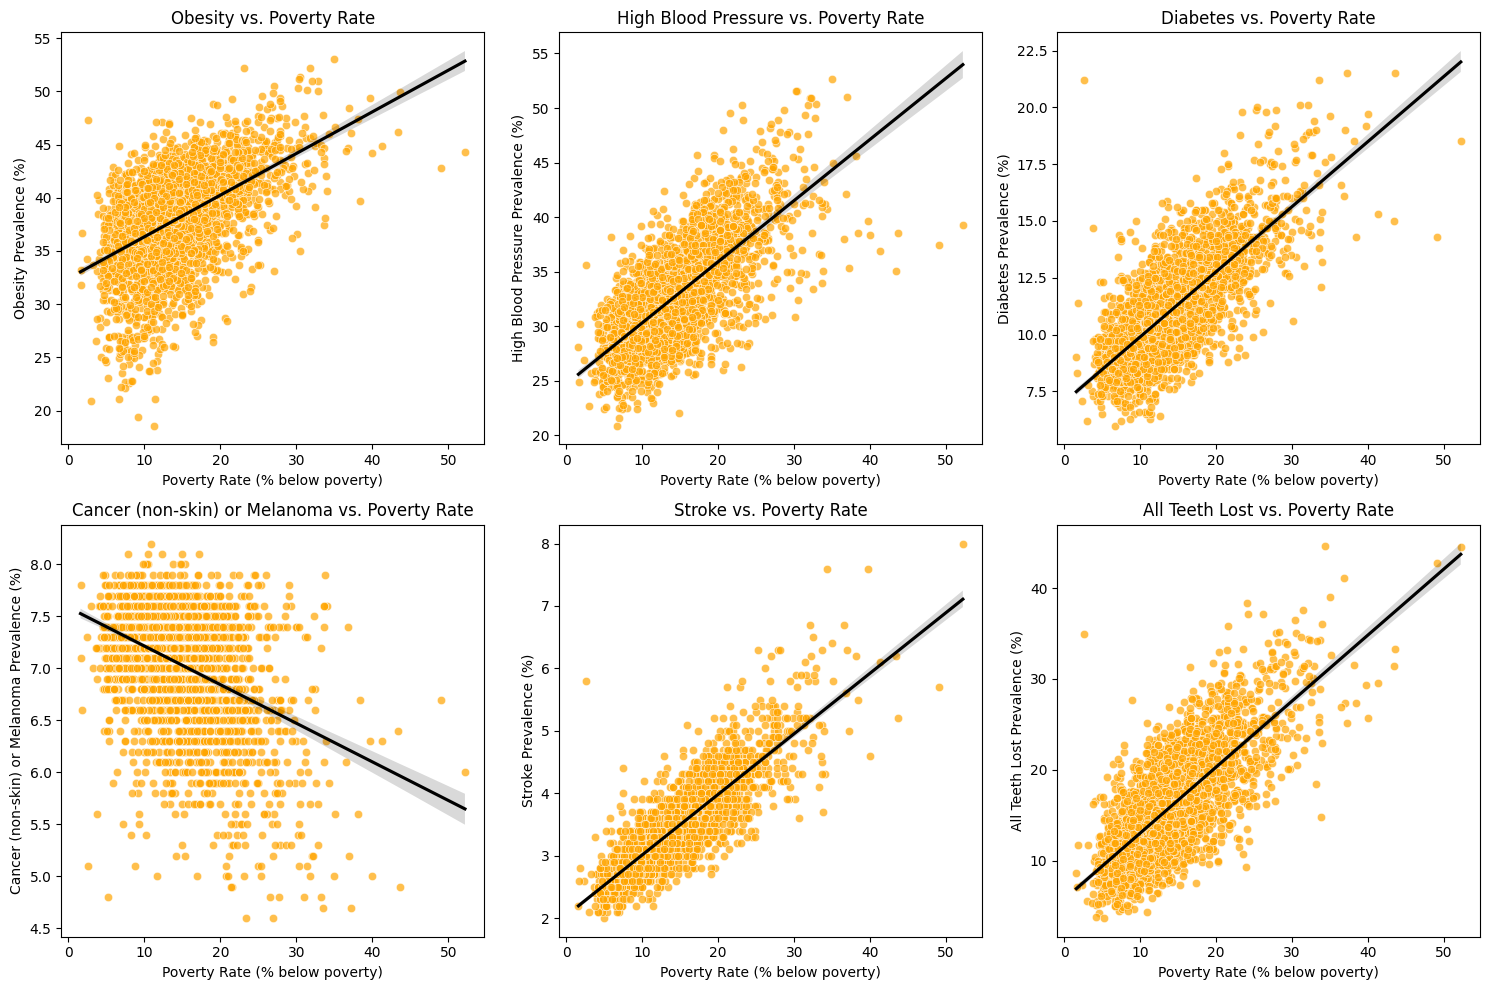

In [20]:
# Define a list of commonly known health outcomes for analysis
key_health_outcomes = ['Obesity', 'High Blood Pressure', 'Diabetes', 'Cancer (non-skin) or Melanoma', 'Stroke', 'All Teeth Lost']

plt.figure(figsize=(15, 10))

for i, outcome in enumerate(key_health_outcomes):
    plt.subplot(2, 3, i+1)

    # Filter data for the selected outcome
    outcome_data = df[df["Health_Measure"] == outcome]
    
    # Create scatter plot with a regression line
    sns.scatterplot(
        x=outcome_data["BP_ Total%"], 
        y=outcome_data["Pop_Percent"],  
        color="orange", 
        alpha=0.7,
        legend=False
    )

    sns.regplot(
        x=outcome_data["BP_ Total%"], 
        y=outcome_data["Pop_Percent"], 
        scatter=False, 
        color='black'
    )
    
    plt.xlabel("Poverty Rate (% below poverty)")
    plt.ylabel(f"{outcome} Prevalence (%)")
    plt.title(f"{outcome} vs. Poverty Rate")
    
plt.tight_layout()
plt.show()

#### This scatterplot with a regression line visualizes the relationship between **poverty rates** and **health outcomes**, highlighting how prevalence changes as poverty levels rise.  

### **🔍 Inference** 

1. **Clear Positive Trends**  
- Four conditions—**Obesity**, **High Blood Pressure**, **Diabetes**, and **Stroke**—exhibit upward trends, meaning they become more prevalent as poverty rates increase.  
- This suggests a strong correlation between higher poverty levels and the worsening of these chronic conditions.  

2. **Strongest Association: Stroke**  
- Among these conditions, Stroke has the steepest regression slope, suggesting it is most sensitive to poverty rate changes.  

3. **Cancer (Non-Skin or Melanoma): The Exception**  
- Unlike other conditions, **Cancer** shows a weaker or slightly negative slope, meaning its prevalence is less affected by poverty levels.  

4. **Distribution & Spread of Data Points**  
- The scatter cloud varies for different conditions:  
  - Obesity values are clustered between 25% and 45%, indicating that obesity is widespread but does not fluctuate dramatically between counties.  
  - Stroke prevalence ranges from 2% to significantly higher values, suggesting it may be more influenced by multiple factors.
 
5. **Regression Line & Outliers**  
- The black regression line visualizes the overall trend, reinforcing the relationship between poverty and health outcomes.  
- However, outliers exist at both extremes:  
  - Low-poverty counties with unexpectedly high health risks.  
  - High-poverty counties with better-than-expected health outcomes.

## 2. Boxplot: Health Outcome by Poverty Category 📊

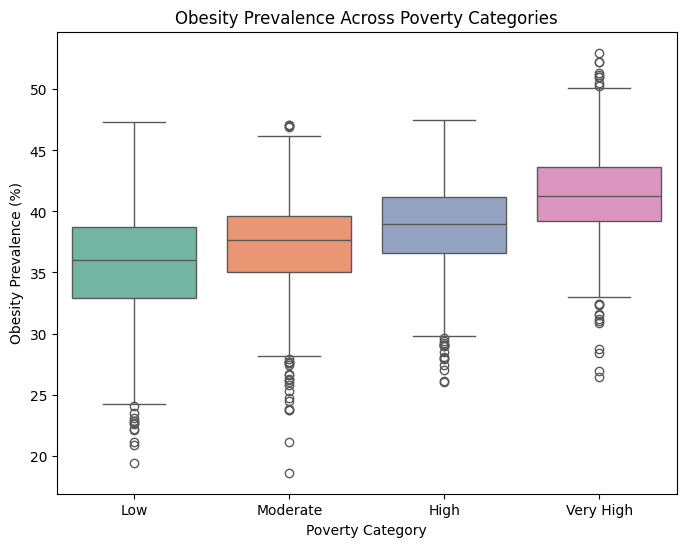

In [21]:
# Create a new column to define poverty categories (quartiles)
df['Poverty_Category'] = pd.qcut(df['BP_ Total%'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'])

# Generate a boxplot for Obesity prevalence across poverty categories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Poverty_Category', 
            y='Pop_Percent', 
            data=df[df["Health_Measure"] == "Obesity"], 
            palette='Set2')
plt.xlabel("Poverty Category")
plt.ylabel("Obesity Prevalence (%)")
plt.title("Obesity Prevalence Across Poverty Categories")
plt.show()

#### Counties are divided into four poverty levels—**Low**, **Moderate**, **High**, and **Very High**—based on the distribution of **BP_Total%** (poverty rate).  

### **🔍 Inference** 

1. **Increasing Median Lines**  
- As we move from **Low** to **Very High** poverty, the **median obesity prevalence consistently increases**.  
- This aligns with the positive correlation observed in scatter plots, reinforcing the link between higher poverty levels and increased obesity rates.  

2. **Overlap Between Boxes**  
- Some overlap exists between categories:  
  - The upper quartile of the Low poverty boxplot extends into the range of Moderate poverty outliers.  
- This suggests that while poverty is a key factor, other influences cause variability in obesity rates across counties.  

3. **Outliers and Local Variations**  
- Several counties in each category have outliers—counties with exceptionally high or low obesity prevalence. 

## 3. Correlation Bar Plot: Poverty vs. Health Outcomes 📊

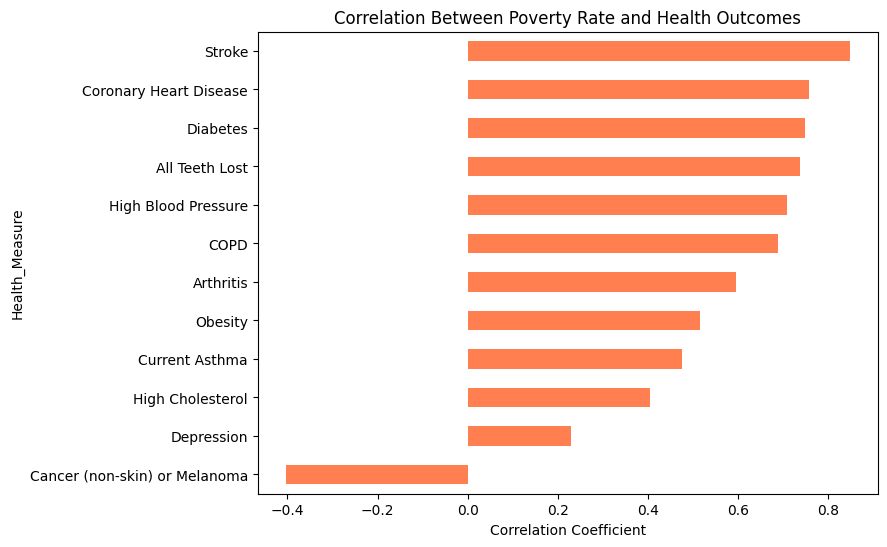

In [22]:
# Use the pivot_disease function to create a pivot table for Health Outcomes
pivot_health = pivot_disease(df)

# Compute correlation coefficients between poverty rate and each health outcome, making sure to select only numeric columns.
numeric_pivot = pivot_health.select_dtypes(include=['number'])

# Now compute the correlation matrix on numeric data only
poverty_correlations = numeric_pivot.corr()['BP_ Total%'].drop('BP_ Total%')

# Plot the correlations as a horizontal bar chart
plt.figure(figsize=(8, 6))
poverty_correlations.sort_values().plot(kind='barh', color='coral')
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Between Poverty Rate and Health Outcomes")
plt.show()

#### Each bar represents the **correlation coefficient** between **BP_Total%** (poverty rate) and a particular health outcome.

### **🔍 Inference** 

1. **Positive vs. Negative Correlations**  

- Bars extending to the right of zero indicate positive correlations, meaning the condition becomes more prevalent as poverty increases (e.g., Stroke, Coronary Heart Disease, Diabetes).  
- Bars extending to the left indicate a negative correlation, meaning the condition is less prevalent in higher-poverty areas (Cancer).   

2. **Relative Strength of Correlations**  

- Stroke has the strongest positive correlation, reinforcing the earlier observation that stroke prevalence is highly sensitive to poverty levels.  
- Cancer is the only condition with a negative correlation, suggesting that higher poverty may be linked to lower reported prevalence—possibly due to differences in screening rates, diagnostic access, or underreporting in poorer counties.  
  

3. **Moderate to Strong Correlations**  

- Most conditions—Arthritis, Obesity, High Cholesterol, High Blood Pressure, and Diabetes—fall in the moderate to strong positive correlation range (0.3–0.7), suggesting a consistent association between poverty and these chronic diseases.  
- Depression (~0.2 correlation) shows a weaker relationship with poverty, indicating that mental health outcomes are influenced by additional socioeconomic or cultural factors beyond income alone.  

## 4. Grouped Bar Chart: Average Health Outcome Prevalence 📊

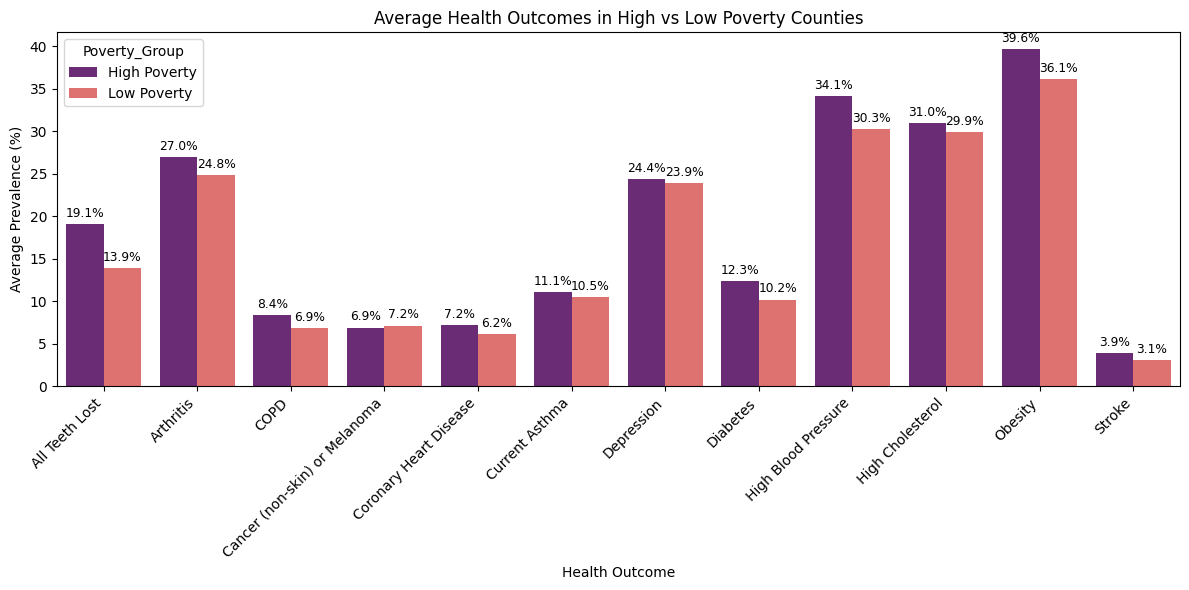

In [23]:
# Filter for Health Outcomes only
health_outcomes_df = df[df["Category"] == "Health Outcomes"].copy()

# Compute a county-level poverty measure by taking the average of BP_ Total% per county (using County and State)
county_poverty = (
    health_outcomes_df.groupby(["County", "State"], as_index=False)["BP_ Total%"]
    .mean()
)

# Sort counties by poverty rate (lowest first)
county_poverty_sorted = county_poverty.sort_values("BP_ Total%")

# Select the bottom 10 (low poverty) and top 10 (high poverty) counties
low_poverty_counties = county_poverty_sorted.head(10)[["County", "State"]]
high_poverty_counties = county_poverty_sorted.tail(10)[["County", "State"]]

# Create a new column "Poverty_Group" and tag counties accordingly
health_outcomes_df["Poverty_Group"] = "Middle"  # default
health_outcomes_df.loc[
    health_outcomes_df["County"].isin(high_poverty_counties["County"]), "Poverty_Group"
] = "High Poverty"
health_outcomes_df.loc[
    health_outcomes_df["County"].isin(low_poverty_counties["County"]), "Poverty_Group"
] = "Low Poverty"

# Filter to include only high and low poverty counties
filtered_health = health_outcomes_df[health_outcomes_df["Poverty_Group"].isin(["High Poverty", "Low Poverty"])]

# Group by Health_Measure and Poverty_Group and calculate the average prevalence
group_summary = (
    filtered_health.groupby(["Health_Measure", "Poverty_Group"])["Pop_Percent"]
    .mean()
    .reset_index()
)

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=group_summary,
    x="Health_Measure",
    y="Pop_Percent",
    hue="Poverty_Group",
    palette="magma"
)

for container in ax.containers:
    ax.bar_label(
        container, 
        fmt="%.1f%%", 
        padding=3, 
        fontsize=8.8,
    )

plt.xlabel("Health Outcome")
plt.ylabel("Average Prevalence (%)")
plt.title("Average Health Outcomes in High vs Low Poverty Counties")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### This chart contrasts the **highest-poverty** and **lowest-poverty** counties, highlighting **average prevalence** for various health outcomes. Each pair of bars represents a health measure, typically showing **higher prevalence** in the **high-poverty group**.  

### **🔍 Inference** 

1. **Positive vs. Negative Differences**  
- Taller bars in high-poverty counties suggest a positive association between poverty and conditions like Stroke, Obesity, High Blood Pressure, and Diabetes.  
- Cancer remains an exception, with slightly higher prevalence in low-poverty counties—reinforcing its previously observed negative correlation with poverty. 

2. **Largest vs. Smallest Gaps**  
- Conditions with the largest differences (e.g., Stroke, All Teeth Lost) suggest a strong link between poverty and health disparities.  
- Conditions with smaller gaps (e.g., Current Asthma) indicate that not all health outcomes are equally influenced by socioeconomic status.

## 5. Boxplot: Distribution of Health Outcomes 📊

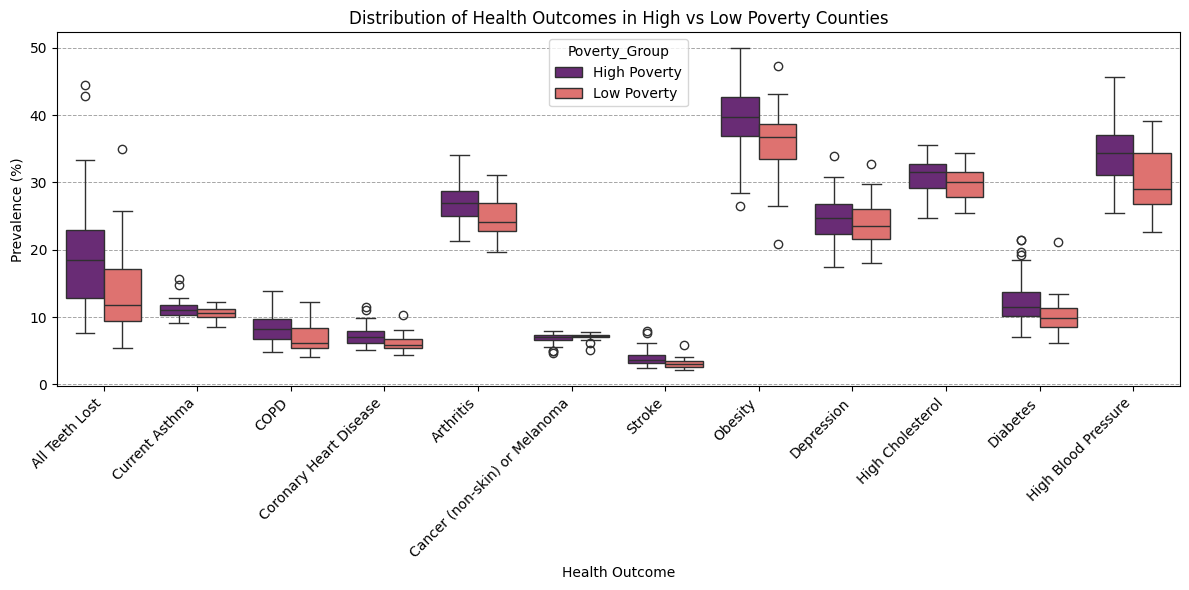

In [24]:
# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_health,
    x="Health_Measure",
    y="Pop_Percent",
    hue="Poverty_Group",
    palette="magma"
)

# Add grey gridlines to help estimate quantile values
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.7, alpha=0.7)

plt.xlabel("Health Outcome")
plt.ylabel("Prevalence (%)")
plt.title("Distribution of Health Outcomes in High vs Low Poverty Counties")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Why Use a Box Plot?**  
Unlike a bar chart, which shows only an **average**, a box plot reveals:  
- The **median line** (central tendency).  
- The **interquartile range (IQR)** (middle 50% of values).  
- **Outliers**, which highlight counties with unusually high or low prevalence rates.  

### **🔍 Inference** 

1. **Higher Medians in High-Poverty Counties**  
- For conditions like **Stroke, High Blood Pressure, Diabetes, and Obesity**, the purple boxes (high-poverty counties) sit above the pink boxes (low-poverty counties).  
- This reinforces the consistent trend that poverty is associated with higher prevalence of these health issues.  

2. **Cancer as an Outlier**  
- **Cancer** does not follow the same pattern:  
  - The difference between high- and low-poverty groups is minimal or even inverted in some cases.  
  - This aligns with earlier observations from the correlation analysis and bar charts, suggesting external factors may play a larger role.  

3. **Distribution & Spread**  
- **Conditions with a Wider Spread (More Variability):**  
  - **All Teeth Lost, Diabetes, Depression** → The low-poverty group has a broader range, suggesting that not all low-poverty counties experience equal health benefits.  
- **Conditions with a Narrower Spread:**  
  - **Current Asthma, COPD** → These show a higher median in high-poverty counties but with less variability, meaning prevalence is more consistently elevated. 

## 📖 Synthesis
### Question 1: How does the relationship between poverty rates and health outcomes vary across U.S. counties and do high-poverty areas experience significantly worse health outcomes compared to wealthier counties?
#### The relationship between poverty levels and health outcomes across U.S. counties demonstrates a strong correlation, with **high-poverty areas experiencing significantly worse health outcomes compared to wealthier counties, particularly for chronic diseases**. While poverty is a significant predictor, the extent of its impact varies based on regional and demographic differences, as well as healthcare access and lifestyle factors.
### **Health Conditions**
#### Higher poverty rates are strongly associated with an increased prevalence of **obesity, high blood pressure, diabetes, and stroke**. Among these, stroke exhibits the steepest regression slope, indicating its pronounced sensitivity to economic disparities. Possible explanations include limited healthcare access, heightened stress levels, and poor diet quality, which exacerbate cardiovascular conditions (Marmot, 2005). The clustering of obesity values between 25% and 45% suggests that, while widespread, obesity is not as variable as other conditions like diabetes, which show larger county-level fluctuations. These trends can be attributed to food deserts, which disproportionately affect low-income communities. High-poverty areas have fewer supermarkets and more fast-food outlets, leading to poor dietary choices and higher obesity rates (Larson et al). Stress and financial instability also contribute to higher cortisol levels, which have been linked to obesity and cardiovascular diseases (Adam & Epel, 2007).
#### Conversely, **cancer** follows a more stable trend, showing a weaker or slightly negative correlation with poverty compared to cardiovascular and metabolic diseases. This suggests that factors beyond income, such as access to screenings, genetic predispositions, or environmental exposures, play a crucial role in its prevalence. Lower-income populations have reduced access to early cancer screenings, leading to underreporting rather than a true decrease in prevalence (Ward et al., 2004). The correlation might also reflect occupational differences, as wealthier individuals may be exposed to workplace carcinogens at a higher rate (Blair & Marrett, 2010).
#### **Depression**, with a weak correlation presents a more complex relationship. The stigma around mental health in lower-income communities combined with a lack of access to mental health services is well documented. This could contribute to underreporting (Davis et al., 2008). In contrast, wealthier states such as New Hampshire report higher depression rates, which could stem from greater mental health awareness and accessibility rather than actual increased incidence.
#### **Oral health** disparities strongly reflect economic inequalities, with **tooth loss** prevalence significantly higher in high-poverty states. The extreme variation in tooth loss (ranging from 9.86% in New Hampshire to 22.75% in Mississippi) underscores the role of dental care accessibility and affordability in health outcomes. Dental care is often omitted from standard healthcare coverage, disproportionately affecting low-income populations (Griffin et al., 2012).
### **Impact of Poverty**
#### **Regional analysis highlights significant disparities between high and low poverty states.** Mississippi, one of the poorest states, has an obesity rate of 43.74% and high rates of diabetes and hypertension. These trends are possibly influenced by structural issues such as lower healthcare funding, fewer primary care providers, and higher uninsured rates (Bailey et al., 2017). In contrast, wealthier states like New Hampshire show better overall health indicators, yet higher reported depression rates, possibly due to better diagnostic practices.
#### Further analysis of counties by poverty quartiles reveals a strong link between economic status and obesity, though some overlap exists due to localized public health initiatives. For instance, New York City’s ban on trans fats and its calorie-labeling laws have helped mitigate obesity even in lower-income neighborhoods (Restrepo & Rieger, 2016). However, some wealthier regions still exhibit poor health outcomes, likely due to disparities in access to preventive care and lifestyle choices.
### **Wealth Disparity**
#### **A state-level comparison highlights that chronic diseases are most severe in states with higher poverty levels.** Mississippi, for instance, consistently ranks highest in obesity and high blood pressure, while wealthier states like New Hampshire have significantly lower rates. The prevalence of conditions such as **diabetes and coronary heart disease** aligns closely with long-term healthcare accessibility, dietary patterns, and socioeconomic stressors (Braveman et al., 2011).
#### **Oral health disparities are among the most striking, with lower-income populations experiencing significantly worse dental health.** The National Institute of Dental and Craniofacial Research (2018) found that individuals below the poverty line are twice as likely to suffer from untreated dental issues due to lack of affordable dental care. Similarly, **chronic conditions such as obesity and high blood pressure are more prevalent in low-income areas**, largely due to food insecurity, sedentary lifestyles, and limited healthcare access (Seligman, Laraia, & Kushel, 2010).
#### Unlike chronic diseases, **mental health trends do not follow a straightforward poverty gradient**. Depression rates are paradoxically higher in wealthier states such as New Hampshire and Montana, while Mississippi reports the lowest rate. This discrepancy may be attributed to underreporting in high-poverty areas due to stigma, limited mental health services, or cultural barriers (Kessler et al., 2003). Additionally,wealthier areas may report higher rates due to greater mental health awareness and diagnosis.

#### This synthesis confirms that poverty remains a crucial determinant of health disparities across U.S. counties, emphasizing the need for targeted public health interventions in low-income areas. The findings confirm that while poverty is a major determinant of health, the relationship is complex and influenced by additional factors such as **regional healthcare availability, cultural behaviors, and public health interventions**. Cardiovascular and metabolic diseases are highly sensitive to economic disparities, reinforcing the need for **targeted healthcare policies in high-poverty regions**. Meanwhile, conditions like **cancer and depression** suggest that **non-economic factors, including genetic and social determinants of health, also play critical roles**. Addressing these disparities requires **multi-faceted interventions** that go beyond income-based solutions to incorporate **education, preventive care, and mental health support**Counties with unexpectedly better health outcomes despite high poverty may benefit from **effective public health initiatives** and **government interventions**. Conversely, some low-poverty counties experience higher-than-expected health risks, possibly due to **lifestyle choices, lack of health education, or environmental exposures**. This reinforces the idea that **income alone does not dictate health outcomes**—a comprehensive public health approach is necessary to mitigate disparities (Wilkinson & Pickett, 2009).


**References**
- Marmot, M. (2005). Social determinants of health inequalities. *The Lancet, 365*(9464), 1099-1104.
- Larson, N. I., Story, M. T., & Nelson, M. C. (2009). "Neighborhood environments: Disparities in access to healthy foods in the U.S." American Journal of Preventive Medicine, 36(1), 74-81. 
- Adam, T. C., & Epel, E. S. (2007). "Stress, eating, and the reward system." Physiology & Behavior, 91(4), 449-458.
- Ward, E., Jemal, A., Cokkinides, V., et al. (2004). "Cancer disparities by race/ethnicity and socioeconomic status." CA: A Cancer Journal for Clinicians, 54(2), 78-93.
- Blair, A., & Marrett, L. (2010). "Occupational cancer epidemiology in the U.S." Environmental Health Perspectives, 118(7), 1025-1030.
- Davis, J. A., Smith, T. W., & Marsden, P. V. (2008). "General Social Surveys, 1972-2008." NORC at the University of Chicago.
- Griffin, S. O., Jones, J. A., Brunson, D., Griffin, P. M., & Bailey, W. D. (2012). Burden of oral disease among older adults and implications for public health priorities. *American Journal of Public Health, 102*(3), 411-418.
- Bailey, S. R., O'Malley, J. P., Gold, R., Heintzman, J., Likumahuwa, S., & DeVoe, J. E. (2017). "Receipt of diabetes preventive services differs by insurance status at visit." American Journal of Preventive Medicine, 52(6), 735-739.
- Restrepo, B., & Rieger, M. (2016). "Trans fat and cardiovascular disease mortality: Evidence from bans in restaurants in New York." Journal of Health Economics, 45, 176-196.
- Braveman, P., Egerter, S., & Williams, D. R. (2011). The social determinants of health: Coming of age. *Annual Review of Public Health, 32*(1), 381-398
- Seligman, H. K., Laraia, B. A., & Kushel, M. B. (2010). "Food insecurity is associated with chronic disease among low-income NHANES participants." The Journal of Nutrition, 140(2), 304-310.
- National Institute of Dental and Craniofacial Research. (2018). "Oral health in America: A report of the Surgeon General." National Institutes of Health.
- Phelan, J. C., Link, B. G., & Tehranifar, P. (2010). "Social conditions as fundamental causes of health inequalities: Theory, evidence, and policy implications." Journal of Health and Social Behavior, 51(1_suppl), S28-S40.
- Kessler, R. C., Berglund, P., Demler, O., Jin, R., & Walters, E. E. (2005). Lifetime prevalence and age-of-onset distributions of DSM-IV disorders in the National Comorbidity Survey Replication. *Archives of General Psychiatry, 62*(6), 593-602.
- Wilkinson, R., & Pickett, K. (2009). *The spirit level: Why more equal societies almost always do better.* Bloomsbury Publishing.

## 2️⃣ Research Question 2  

### What health risk behaviors are most prevalent in counties with higher poverty rates, and how do these behaviors correlate with disease prevalence?

## 📝 Descriptive Statistics

In [25]:
def pivot_behavior(df):
    # Filter data for Health Risk Behaviors category
    health_risk_behaviors_df = df[df["Category"] == "Health Risk Behaviors"]

    # Pivot the data so each Health Measure becomes a column with Pop_Percent as values
    pivot_df =  health_risk_behaviors_df.pivot_table(index=["County", "State", "BP_ Total%"], 
                                            columns="Health_Measure", 
                                            values="Pop_Percent").reset_index()

    return pivot_df

pivot_behavior(df).describe()

Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
count,2942.00,2942.00,2942.00,2942.00,2942.00
mean,14.39,18.74,18.05,26.48,37.35
std,5.97,2.83,3.82,5.16,4.05
min,1.60,9.40,5.90,11.80,24.70
25%,10.10,16.70,15.60,22.90,34.40
50%,13.50,18.80,17.80,26.10,37.70
75%,17.50,20.60,20.40,29.90,40.20
max,52.20,27.50,38.30,47.30,51.00


### **🔍 Inference**  

1. **Binge Drinking is Fairly Consistent Across Counties:**  
   - The mean prevalence is 18.74%, with a narrow range (9.4% – 27.5%), meaning it’s more stable compared to other behaviors.  
   - The low standard deviation (2.83) suggests most counties are similar in terms of binge drinking rates.  
   - The middle 50% of counties have rates between 16.7% and 20.6%, showing less extreme variation.   

2. **Smoking Rates Differ More Across Counties:**  
   - Mean smoking prevalence = 18.05%, with some counties as low as 5.9% and others as high as 38.3%.  
   - Standard deviation (3.82) is higher than binge drinking, indicating more variation in smoking rates.  
   - 50% of counties fall between 15.6% and 20.4%, but outliers exist.  

3. **Physical Inactivity is a Major Concern in Some Areas:**  
   - Mean = 26.48%, meaning over 1 in 4 adults are physically inactive on average.  
   - Large range (11.8% – 47.3%) suggests some counties have extreme inactivity levels.  
   - The standard deviation (5.16) is relatively high, indicating strong regional differences.  

4. **Short Sleep Duration is Widespread and High:**  
   - Mean = 37.35%, meaning over 1 in 3 adults report insufficient sleep.  
   - Counties range from 24.7% to 51.0%, meaning some areas have a majority of residents experiencing sleep deprivation.  
   - Middle 50% of counties fall between 34.4% and 40.2%, showing a consistent trend of sleep deprivation nationwide.  

We will explore **how these risk behaviors correlate with health outcomes like obesity, heart disease, and diabetes** further down the line.

In [26]:
pivot_behavior(most_poor_df).describe()

Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
count,81.00,81.00,81.00,81.00,81.00
mean,21.99,14.57,20.46,33.87,40.03
std,5.87,1.59,2.57,4.09,3.25
min,9.50,10.80,13.60,24.60,32.20
25%,18.20,13.70,18.90,31.40,38.20
50%,21.50,14.70,20.50,33.70,39.90
75%,25.70,15.60,22.40,36.50,42.20
max,37.00,17.60,26.00,44.40,47.00


In [27]:
pivot_behavior(mean_poor_df).describe()

Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
count,48.00,48.00,48.00,48.00,48.00
mean,13.55,23.15,17.42,22.76,33.42
std,6.20,1.47,3.77,3.40,2.75
min,2.40,19.20,11.60,15.70,27.90
25%,9.70,22.58,14.97,20.65,31.77
50%,12.10,23.25,16.90,22.40,33.10
75%,16.90,23.90,18.47,24.10,34.58
max,31.50,26.40,30.40,32.50,42.50


In [28]:
pivot_behavior(least_poor_df).describe()

Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
count,10.00,10.00,10.00,10.00,10.00
mean,8.68,19.03,14.06,19.53,34.03
std,2.12,1.10,2.07,1.77,1.16
min,4.80,17.90,10.30,17.00,32.00
25%,7.40,18.25,12.72,18.00,33.15
50%,8.80,18.80,14.80,19.35,34.45
75%,9.70,19.45,15.07,21.05,34.60
max,11.70,21.60,17.50,22.00,35.50


### **🔍 Inference**  

1. **Higher Poverty is Associated with Worse Health Behaviors**  
   - Physical Inactivity is highest in the most poor state (33.87%), compared to the mean-poor state (22.76%) and the richest state (19.53%).  
   - Short Sleep Duration is also highest in the poorest state (40.03%), compared to the mean-poor state (33.42%) and the richest state (34.03%).  

2. **Binge Drinking is More Prevalent in Wealthier States**  
   - Poorest state: 14.57%, mean-poor state: 23.15%, richest state: 19.03%.  
   - This contradicts the trend seen in physical inactivity and sleep deprivation.

3. **Smoking Rates Are Highest in the Most Poor State**  
   - Poorest state: 20.46%, mean-poor state: 17.42%, richest state: 14.06%.  

4. **Health Behaviors Show More Variation in Poorer States**  
   - The standard deviations for poverty (BP Total%) are high across all three states, meaning economic conditions vary significantly even within a single state.  
   - The most poor state has a wider spread of physical inactivity (min: 24.6%, max: 44.4%), while the richest state has a much smaller range (min: 17.0%, max: 22.0%).
   - This suggests that health behaviors fluctuate more in poorer states.

## 🔬 Inferential Statistics

#### **Null Hypothesis (H₀):**  
There is **no association** between **poverty levels** (`BP_ Total%`) and the prevalence of **health risk behaviors** (Smoking, Physical Inactivity, Short Sleep Duration) in different counties.

#### **Alternative Hypothesis (H₁):**  
There **is an association** between **poverty levels** (`BP_ Total%`) and the prevalence of **health risk behaviors** (Smoking, Physical Inactivity, Short Sleep Duration) in different counties

In [29]:
# Filter dataset for only Health Outcomes
health_risk_behaviors = df[df["Category"] == "Health Risk Behaviors"]["Health_Measure"].unique()

# List to store regression results
results_list = []

# Loop through each health outcome and run OLS regression
for behavior in health_risk_behaviors:
    subset_df = df[df["Health_Measure"] == behavior]

    # Independent variable: Poverty Rate
    X = subset_df["BP_ Total%"]
    y = subset_df["Pop_Percent"]

    # Add constant (intercept)
    X = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    # Store results in a list
    results_list.append({
        "Health Risk Behavior": behavior,
        "R²": round(model.rsquared, 3),
        "P-Value": f"{model.pvalues['BP_ Total%']}",  # Display full precision
        "Coefficient": round(model.params["BP_ Total%"], 3)
    })

# Convert results to a DataFrame and sort by R²
results_df = pd.DataFrame(results_list).sort_values(by="R²", ascending=False)

# Display the final structured results
print("OLS Regression Results: Poverty vs Health Risk Behavior")
results_df

OLS Regression Results: Poverty vs Health Risk Behavior


,Health Risk Behavior,R²,P-Value,Coefficient
2,Physical Inactivity,0.49,0.0,0.61
3,Current Cigarette Smoking,0.40,0.0,0.41
1,Binge Drinking,0.33,6.15000699560586e-262,-0.27
0,Short Sleep Duration,0.33,1.56782964060756e-258,0.39


#### **🔍 So, Do We Reject the Null Hypothesis?**  

Yes, **we still reject the null hypothesis** as the **p-values** are less than **0.001** across the board.

### **🔍 Inference**  

1. **Physical Inactivity is the Most Affected by Poverty**  
- R² = 0.49. Nearly half of the variation in physical inactivity is explained by poverty.  
- Coefficient = 0.61. A 1% increase in poverty rate leads to a 0.61% increase in physical inactivity.  
- This suggests that low-income areas may have fewer safe spaces for exercise, lower access to fitness facilities, and higher rates of sedentary jobs.  

2. **Smoking is Also Strongly Correlated with Poverty**  
- R² = 0.40, Coefficient = 0.41. Higher poverty rates are linked to higher smoking rates.  
- This is likely due to higher stress levels, targeted tobacco marketing in low-income areas, and lower access to smoking cessation programs.  

3. **Short Sleep Duration is More Common in Poorer Areas**  
- R² = 0.33, Coefficient = 0.39. As poverty increases, so does sleep deprivation.  
- Factors like unstable work schedules, job-related stress, and housing conditions may contribute to this trend.  

4. **Binge Drinking is More Common in Wealthier Areas**  
- R² = 0.33, Coefficient = -0.27. Unlike other behaviors, binge drinking decreases as poverty increases.  
- This suggests that higher-income individuals engage in more social drinking, possibly due to greater access to alcohol and social events.  

#### **Null Hypothesis (H₀):**  
There is **no association** between **health outcomes** (Obesity, Cancer, All Teeth Lost, etc.) and the prevalence of **health risk behaviors** (Smoking, Physical Inactivity, Short Sleep Duration) in different counties.

#### **Alternative Hypothesis (H₁):**  
There **is an association** between **health outcomes** (Obesity, Cancer, All Teeth Lost, etc.) and the prevalence of **health risk behaviors** (Smoking, Physical Inactivity, Short Sleep Duration) in different counties

In [30]:
# Dictionary to store results for each HRB vs. all Health Outcomes
ols_results = {}

# Loop through each Health Risk Behavior
for behavior in health_risk_behaviors:
    results_list = []
    
    # Loop through each Health Outcome
    for outcome in health_outcomes:
        subset_df = df[(df["Health_Measure"] == behavior) | (df["Health_Measure"] == outcome)]
        
        # Pivot the data so each measure is a column
        pivot_df = subset_df.pivot_table(index=["County", "State"], columns="Health_Measure", values="Pop_Percent")

        # Drop columns with NaN values
        pivot_df = pivot_df.dropna(axis=0)

        # Check if both variables exist after NaN removal
        if behavior not in pivot_df.columns or outcome not in pivot_df.columns:
            continue

        # Independent variable (Health Risk Behavior)
        X = pivot_df[behavior]
        y = pivot_df[outcome]

        # Add constant (intercept)
        X = sm.add_constant(X)

        # Fit OLS model
        model = sm.OLS(y, X).fit()

        # Store results in a list
        results_list.append({
            "Health Outcome": outcome,
            "R²": round(model.rsquared, 3),
            "P-Value": f"{model.pvalues[behavior]:.10f}",  # Full precision p-value
            "Coefficient": round(model.params[behavior], 3)
        })

    # Convert results to a DataFrame and store it in dictionary
    results_df = pd.DataFrame(results_list).sort_values(by="R²", ascending=False)
    ols_results[behavior] = results_df  # Store each behavior's table separately

# Display results for each Health Risk Behavior
for behavior, table in ols_results.items():
    print(f"\nOLS Regression: {behavior} vs Health Outcomes")
    display(table)



OLS Regression: Short Sleep Duration vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
3,Diabetes,0.58,0.0000000000,0.43
9,High Blood Pressure,0.56,0.0000000000,0.87
2,COPD,0.48,0.0000000000,0.31
5,Stroke,0.46,0.0000000000,0.11
11,Arthritis,0.44,0.0000000000,0.48
7,Coronary Heart Disease,0.44,0.0000000000,0.15
0,All Teeth Lost,0.40,0.0000000000,0.92
8,High Cholesterol,0.36,0.0000000000,0.34
6,Obesity,0.33,0.0000000000,0.65
1,Current Asthma,0.17,0.0000000000,0.10



OLS Regression: Binge Drinking vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
9,High Blood Pressure,0.55,0.0000000000,-1.23
3,Diabetes,0.48,0.0000000000,-0.56
5,Stroke,0.39,0.0000000000,-0.15
0,All Teeth Lost,0.34,0.0000000000,-1.22
2,COPD,0.33,0.0000000000,-0.36
8,High Cholesterol,0.32,0.0000000000,-0.46
11,Arthritis,0.30,0.0000000000,-0.57
7,Coronary Heart Disease,0.30,0.0000000000,-0.17
1,Current Asthma,0.17,0.0000000000,-0.14
6,Obesity,0.14,0.0000000000,-0.60



OLS Regression: Physical Inactivity vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
3,Diabetes,0.78,0.0000000000,0.39
7,Coronary Heart Disease,0.74,0.0000000000,0.15
5,Stroke,0.69,0.0000000000,0.11
9,High Blood Pressure,0.63,0.0000000000,0.73
2,COPD,0.62,0.0000000000,0.27
6,Obesity,0.58,0.0000000000,0.67
0,All Teeth Lost,0.55,0.0000000000,0.84
11,Arthritis,0.41,0.0000000000,0.36
8,High Cholesterol,0.34,0.0000000000,0.26
4,Cancer (non-skin) or Melanoma,0.26,0.0000000000,-0.05



OLS Regression: Current Cigarette Smoking vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
2,COPD,0.82,0.0000000000,0.42
7,Coronary Heart Disease,0.74,0.0000000000,0.20
11,Arthritis,0.62,0.0000000000,0.60
5,Stroke,0.60,0.0000000000,0.14
0,All Teeth Lost,0.52,0.0000000000,1.11
6,Obesity,0.44,0.0000000000,0.79
9,High Blood Pressure,0.41,0.0000000000,0.79
3,Diabetes,0.40,0.0000000000,0.38
1,Current Asthma,0.37,0.0000000000,0.15
10,Depression,0.22,0.0000000000,0.42


#### **🔍 So, Do We Reject the Null Hypothesis?**  

Yes, **we still reject the null hypothesis** as the **p-values** are less than **0.001** across the board.


#### Let us use correlation to see the strongest relationships between **health risk behaviors** and **health outcomes**.

In [31]:
# Filter dataset for only Health Outcomes & Health Risk Behaviors
filtered_df = df[df["Category"].isin(["Health Outcomes", "Health Risk Behaviors"])]

# Pivot data: Each health measure becomes a column, with Pop_Percent as values
numeric_df = filtered_df.pivot_table(index=["County", "State"], columns="Health_Measure", values="Pop_Percent")

# Separate Risk Behaviors & Outcomes
risk_behaviors = df[df["Category"] == "Health Risk Behaviors"]["Health_Measure"].unique()
health_outcomes = df[df["Category"] == "Health Outcomes"]["Health_Measure"].unique()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Extract correlations between Risk Behaviors (rows) and Health Outcomes (columns)
corr_df = corr_matrix.loc[risk_behaviors, health_outcomes]

# Ensure proper names before unstacking
corr_df.index.name = "Health Outcome"
corr_df.columns.name = "Health Risk Behavior"

# Unstack
corr_melted = corr_df.unstack().reset_index()
corr_melted.columns = ["Health Outcome", "Health Risk Behavior", "Correlation"]

# Rank by absolute correlation
corr_melted["Correlation_abs"] = corr_melted["Correlation"].abs()
top_5_corr = corr_melted.sort_values(by="Correlation_abs", ascending=False).head(5)

# Display results
print("Top 5 Strongest Correlations Between Health Risk Behaviors & Health Outcomes:")
top_5_corr

Top 5 Strongest Correlations Between Health Risk Behaviors & Health Outcomes:


,Health Outcome,Health Risk Behavior,Correlation,Correlation_abs
11,COPD,Current Cigarette Smoking,0.91,0.91
14,Diabetes,Physical Inactivity,0.88,0.88
31,Coronary Heart Disease,Current Cigarette Smoking,0.86,0.86
30,Coronary Heart Disease,Physical Inactivity,0.86,0.86
22,Stroke,Physical Inactivity,0.83,0.83


### **🔍 Inference**  

1. **Short Sleep Duration is Strongly Linked to Chronic Conditions**  
- Diabetes (R² = 0.58), High Blood Pressure (0.56), COPD (0.48), Stroke (0.46), and Arthritis (0.44) all have strong correlations with sleep deprivation.  
- High Coefficient for Blood Pressure (0.87) and Tooth Loss (0.92) suggests that poor sleep significantly worsens cardiovascular health and oral health.  
- Obesity (0.65) and Depression (0.27) also show meaningful relationships, indicating that sleep deprivation could be linked to weight gain and mental health issues. 

2. **Binge Drinking is Associated with *Better* Health Outcomes**  
- Negative coefficients across nearly all health outcomes suggest that higher binge drinking rates are linked to better overall health in this dataset.  
- High Blood Pressure (-1.23), Diabetes (-0.56), and Tooth Loss (-1.22) show strong negative correlations.  
- This contradicts typical public health expectations, suggesting that binge drinking might be more common in wealthier areas with better healthcare access and lifestyle factors.

3. **Physical Inactivity is the Most Predictive of Poor Health Outcomes**  
- Strongest relationships with Diabetes (R² = 0.78), Coronary Heart Disease (0.74), Stroke (0.69), and High Blood Pressure (0.63).  
- Obesity (R² = 0.58, Coef = 0.67) reinforces the well-known connection between lack of exercise and weight gain.  
- Tooth Loss (0.84) and COPD (0.62) correlations are unexpectedly high, suggesting that sedentary lifestyles may contribute to overall poor systemic health.  
- Correlations confirm that Physical Inactivity (0.88) is one of the strongest predictors of Diabetes, highlighting the direct link between lack of exercise and metabolic disorders.  
- Coronary Heart Disease also shows a very strong correlation (0.86) with Physical Inactivity, supporting the idea that regular exercise is crucial for heart health.


4. **Smoking is the Strongest Indicator of Chronic Disease**  
- COPD (R² = 0.82, Coef = 0.42) is the strongest correlation in the entire dataset, confirming the well-known link between smoking and lung disease.  
- Coronary Heart Disease (0.74), Arthritis (0.62), and Stroke (0.60) also have high correlations, highlighting that smoking damages the cardiovascular system and joints.  
- Smoking is the strongest predictor of COPD (0.91 correlation), reinforcing the direct impact of tobacco on lung disease.  
- Coronary Heart Disease also has a strong correlation (0.86) with Smoking, showing that tobacco use is a major driver of heart-related issues.  
- High Blood Pressure (0.41), Diabetes (0.40), and Obesity (0.44) are all moderately linked to smoking, suggesting that smoking may contribute to metabolic syndrome.  
- Tooth Loss (0.52, Coef = 1.11) is another clear finding—smoking significantly impacts oral health.

### 🔍 **Next Steps:** Let's get into the graphical analysis for this section and see what we find!

## 📊 Graphical Analysis

## 1. Health Risk Behaviors vs. Health Outcomes (Correlation Heatmap)

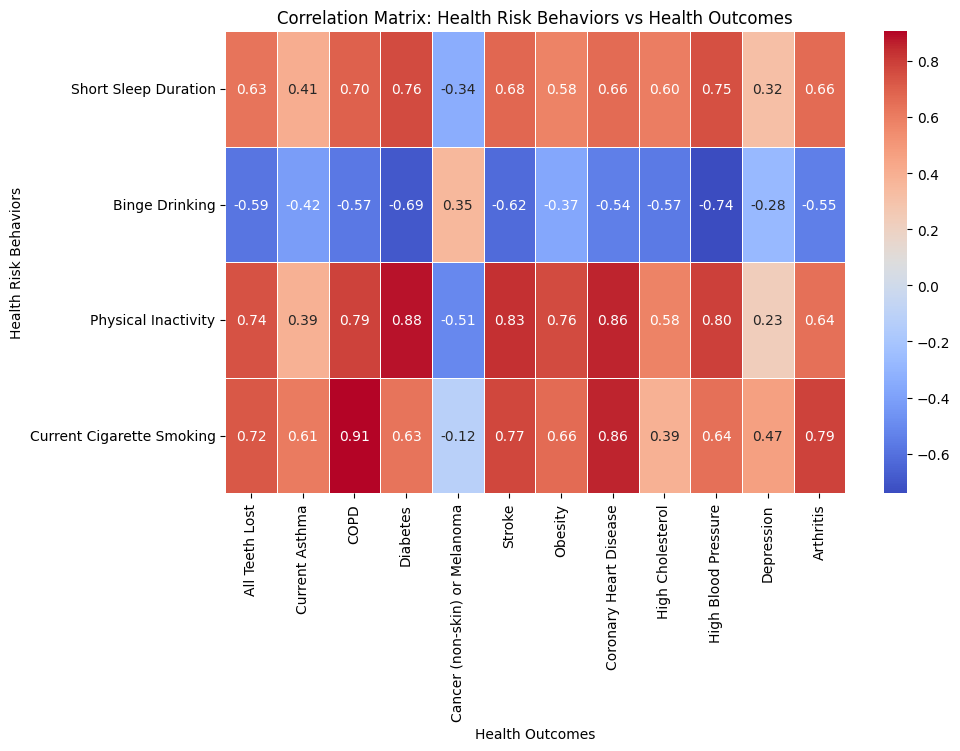

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set labels
plt.title("Correlation Matrix: Health Risk Behaviors vs Health Outcomes")
plt.xlabel("Health Outcomes")
plt.ylabel("Health Risk Behaviors")

# Show plot
plt.show()


#### Each cell represents the **linear correlation coefficient** between a **health risk behavior** (rows) and a **health outcome** (columns). The **color intensity** reflects the strength and direction of the correlation.  

### **Positive vs. Negative Correlations**  
- **Warm colors** (reds) indicate **strong positive correlations**, meaning that as the health risk behavior increases, the corresponding health outcome also tends to increase.  
- **Cool colors** (blues) represent **negative or weaker correlations**, suggesting an inverse or negligible relationship.  

### **🔍 Inference**   

1. **Strong Positive Correlations**  
- Current cigarette smoking is strongly correlated with COPD and other respiratory diseases, reinforcing well-established links between smoking and lung damage.  
- Physical inactivity and short sleep duration exhibit consistent positive correlations with several chronic conditions, suggesting that sedentary lifestyles and poor sleep patterns may contribute to overall health decline.  

2. **Weaker or Negative Correlations**  
- Binge drinking appears to have weak or negative correlations with many health outcomes.  
- One possible explanation is that binge drinking is more prevalent in relatively wealthier populations, where better access to healthcare and other lifestyle factors may mitigate some of its negative effects.  
- However, this claim requires further research to account for confounding factors such as alcohol-related diseases (e.g., liver disease) that might not be captured in this dataset.    

## 2. Selected Risk Behavior vs. Health Outcome (Scatter Plot) 📊

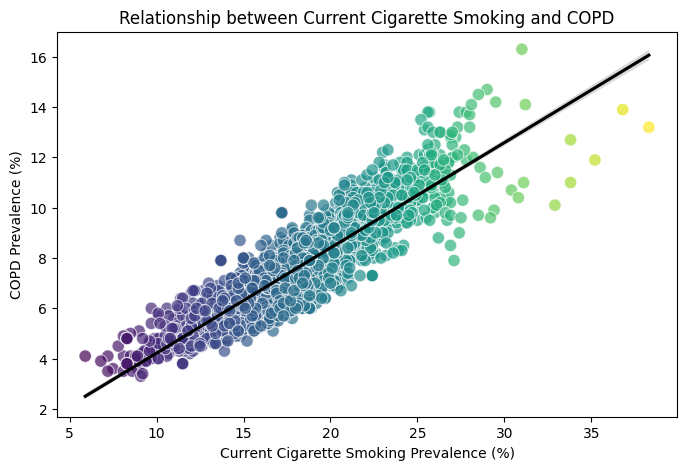

In [33]:
# Using Current Cigarette Smoking and COPD because it's the highest correlation
risk_behavior = "Current Cigarette Smoking"
health_outcome = "COPD"

# Filter the datasets for the selected risk behavior and outcome
risk_df = df[(df["Category"] == "Health Risk Behaviors") & (df["Health_Measure"] == risk_behavior)]
outcome_df = df[(df["Category"] == "Health Outcomes") & (df["Health_Measure"] == health_outcome)]

# Merge the two dataframes on County and State for comparison
merged_df = risk_df.merge(outcome_df, on=["County", "State"], suffixes=('_Risk', '_Outcome'))

plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_df["Pop_Percent_Risk"], 
                y=merged_df["Pop_Percent_Outcome"], 
                c=merged_df["Pop_Percent_Risk"], 
                cmap="viridis", 
                s=80, 
                alpha=0.7)
sns.regplot(x=merged_df["Pop_Percent_Risk"], 
            y=merged_df["Pop_Percent_Outcome"], 
            scatter=False, 
            color='black')
plt.xlabel(f"{risk_behavior} Prevalence (%)")
plt.ylabel(f"{health_outcome} Prevalence (%)")
plt.title(f"Relationship between {risk_behavior} and {health_outcome}")
plt.show()


### Understanding the Bivariate Relationship 
- Each point represents a **county**, with:  
  - **X-axis**: Prevalence of the selected **risk behavior** (e.g., smoking).  
  - **Y-axis**: Prevalence of the corresponding **health outcome** (e.g., COPD).  
- The **black regression line** represents a **linear fit**, helping to visualize the overall trend in the data.  

### 🔍 **Inference**

1. **Strong Positive Trend**  
- Current Cigarette Smoking is strongly correlated** with COPD prevalence.  
- Counties with higher smoking rates generally exhibit higher COPD rates, reinforcing the well-documented link between smoking and lung disease.  


### Additional Considerations

✅ The strength of the trend suggests a direct relationship, but it is important to consider other factors like air pollution, occupational hazards, and healthcare access, which might influence COPD rates alongside smoking.  

✅ Potential Outliers:  
- Some counties may have higher-than-expected COPD rates given their smoking prevalence, possibly due to environmental pollutants or genetic predispositions.  
- Others may have lower-than-expected COPD rates, which could indicate better healthcare systems, smoking cessation programs, or demographic differences (e.g., younger populations).   

## 3. Grouped Bar Chart: Average Prevalence of Health Risk Behaviours for Quartiles of Poverty 📊

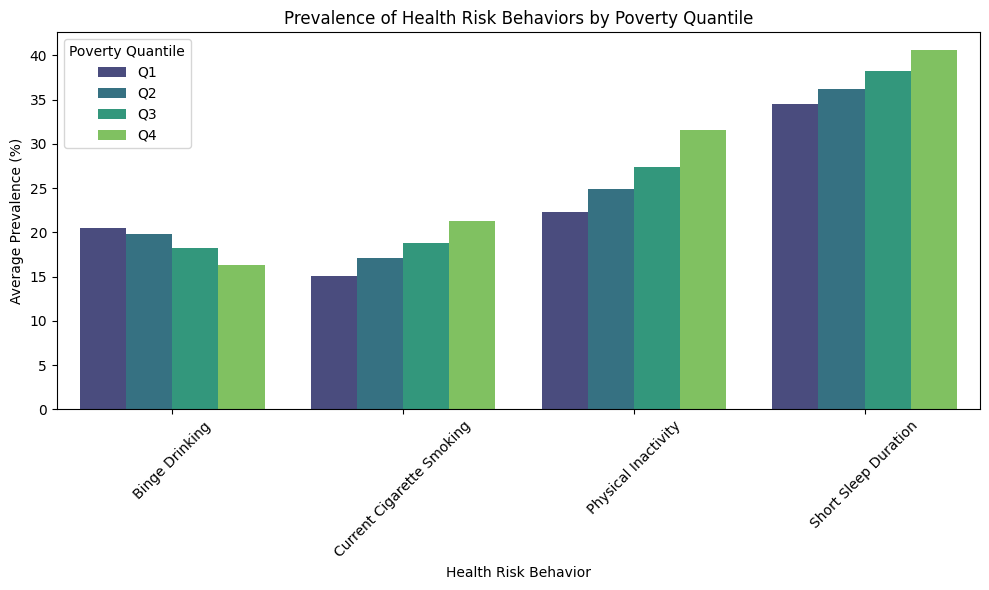

In [34]:
df['Poverty_Quantile'] = pd.qcut(df['BP_ Total%'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Filter the DataFrame for rows in the 'Health Risk Behaviors' category
risk_behaviors_df = df[df["Category"] == "Health Risk Behaviors"]

# Group by risk behavior and poverty quantile, then calculate the mean prevalence for each group
risk_quantile_summary = risk_behaviors_df.groupby(["Health_Measure", "Poverty_Quantile"])["Pop_Percent"].mean().reset_index()

# Plot a grouped bar chart: Health Risk Behavior on the x-axis, average prevalence on the y-axis, and hue as Poverty Quantile
plt.figure(figsize=(10, 6))
sns.barplot(data=risk_quantile_summary, x="Health_Measure", y="Pop_Percent", hue="Poverty_Quantile", palette="viridis")

# Set labels and title
plt.xlabel("Health Risk Behavior")
plt.ylabel("Average Prevalence (%)")
plt.title("Prevalence of Health Risk Behaviors by Poverty Quantile")
plt.xticks(rotation=45)
plt.legend(title="Poverty Quantile")
plt.tight_layout()
plt.show()

### Four Poverty Categories (Quartiles) 
- Counties are grouped into four categories based on poverty levels:  
  - **Q1** → Lowest poverty  
  - **Q2** → Lower-middle poverty  
  - **Q3** → Upper-middle poverty  
  - **Q4** → Highest poverty  


### 🔍 **Inference**

1. **Increasing Trends in High-Poverty Areas** 
- Smoking, physical inactivity, and short sleep duration increase as poverty levels rise (Q1 → Q4).  
  - This suggests that counties with higher poverty rates experience greater prevalence of these risk behaviors.

2. **Decreasing Trend in Binge Drinking**  
- Binge drinking decreases as poverty increases, suggesting it is more common in wealthier populations (Q1 and Q2).   

## 📖 Synthesis

### Question 2: What health risk behaviors are most prevalent in counties with higher poverty rates, and how do these behaviors correlate with disease prevalence?

#### The findings suggest that **health risk behaviors in high-poverty counties are strongly associated with chronic disease prevalence**, reinforcing the long-established link between socioeconomic status and health outcomes.

### **Smoking: The Strongest Predictor of Chronic Disease**
#### Smoking is the most prevalent health risk behavior in high-poverty areas and the strongest predictor of chronic disease. The high correlation between smoking and conditions such as COPD (0.91), coronary heart disease (0.86), and stroke (0.60) underscores the severe health consequences of tobacco use. The disproportionate smoking rates in lower-income areas may be driven by stress, targeted marketing, and reduced access to smoking cessation resources. This aligns with broader public health research indicating that tobacco-related disparities persist due to industry strategies targeting economically disadvantaged populations (Hiscock et al., 2012). Given smoking’s extensive impact on both cardiovascular and pulmonary health, reducing smoking prevalence in these areas could significantly improve overall health outcomes.

### **Physical Inactivity: A Strong Indicator of Poor Systemic Health**
#### Physical inactivity demonstrates one of the strongest correlations with poverty, with nearly half of its variation explained by economic conditions. The association between inactivity and diabetes (0.88), coronary heart disease, and stroke (0.69) highlights how sedentary lifestyles contribute to metabolic and cardiovascular disorders. The high correlation between physical inactivity and tooth loss (0.84) suggests that inactivity may be linked to broader systemic health deterioration. The lack of safe spaces for exercise, sedentary occupations, and limited access to recreational facilities in impoverished areas may exacerbate this issue. Prior studies have found similar associations, with socioeconomic factors playing a critical role in shaping exercise behaviors (Bauman et al., 2012). Interventions targeting physical activity in high-poverty areas could mitigate these health risks and reduce the burden of chronic diseases.

### **Short Sleep Duration: A Widespread and Overlooked Health Concern**
#### Sleep deprivation is another significant health risk behavior disproportionately affecting high-poverty counties. The high correlation between sleep deprivation and hypertension (0.87) and tooth loss (0.92) suggests that chronic sleep insufficiency can have severe cardiovascular and oral health consequences. The link between sleep deprivation and obesity (0.65) and depression (0.27) further supports existing research indicating that insufficient sleep contributes to both metabolic and mental health disorders (Grandner et al., 2010). Factors such as unstable work schedules, job-related stress, and inadequate housing conditions may exacerbate sleep deprivation in low-income populations. Addressing structural determinants of sleep, such as job stability and housing quality, could play a crucial role in improving health outcomes in these areas.

### **Binge Drinking: An Outlier in the Health-Poverty Relationship**
#### Unlike smoking, inactivity, and sleep deprivation, binge drinking follows a different pattern, being more prevalent in wealthier areas and showing weak or negative correlations with many chronic diseases. The inverse relationship between binge drinking and poor health outcomes may reflect differences in drinking patterns across socioeconomic groups, where alcohol consumption in wealthier populations is more controlled or social in nature rather than a coping mechanism linked to poverty. However, this finding should be interpreted cautiously, as confounding factors such as alcohol-related diseases (e.g., liver disease) may not be fully accounted for in the dataset. Future research should examine these nuances further to determine the long-term health effects of binge drinking in different socioeconomic groups.

### **Poverty and Health Risk Behaviors: A Cycle of Disadvantage**
#### The overall pattern of findings reinforces the cyclical relationship between poverty and poor health. High-poverty counties exhibit higher rates of smoking, physical inactivity, and sleep deprivation, all of which are strongly linked to chronic diseases. These behaviors, in turn, contribute to increased rates of diabetes, cardiovascular disease, and respiratory conditions, exacerbating economic hardship by reducing productivity, increasing healthcare costs, and limiting upward mobility (Braveman & Gottlieb, 2014). The variability in health risk behaviors across different economic conditions within states also suggests that while poverty is a key driver, localized factors such as policy interventions and community resources can play a moderating role in shaping health outcomes.

### **Implications for Public Health Interventions**
#### There is a clear requirement for public health interventions here. Addressing these disparities requires targeted, multi-faceted interventions such as smoking cessation programs, especially in high-poverty areas, with policies aimed at reducing tobacco marketing in these communities. Physical activity initiatives, including community exercise spaces and workplace wellness programs, could also be helpful along with sleep health interventions. Binge drinking interventions may require a different approach, focusing on social and cultural influences rather than economic conditions.

**References:**
- Bauman, A. E., Reis, R. S., Sallis, J. F., Wells, J. C., Loos, R. J., & Martin, B. W. (2012). Correlates of physical activity: why are some people physically active and others not? *The Lancet*, 380(9838), 258-271.
- Braveman, P., & Gottlieb, L. (2014). The social determinants of health: it's time to consider the causes of the causes. *Public Health Reports*, 129(Suppl 2), 19-31.
- Grandner, M. A., Patel, N. P., Gehrman, P. R., Perlis, M. L., & Pack, A. I. (2010). Problems associated with short sleep: bridging the gap between laboratory and epidemiological studies. *Sleep Medicine Reviews*, 14(4), 239-247.
- Hiscock, R., Bauld, L., Amos, A., Fidler, J. A., & Munafò, M. (2012). Socioeconomic status and smoking: a review. *Annals of the New York Academy of Sciences*, 1248(1), 107-123.

## 3️⃣ Research Question 3  

### How do poverty rates correlate with health disparities among people of color across different states?

## 📝 Descriptive Statistics  

In [35]:
def pivot_racial_disease(df, racial_BP):
    # Filter data for Health Outcomes category
    health_outcomes_df = df[df["Category"] == "Health Outcomes"]

    # Pivot the data so each Health Measure becomes a column with Pop_Percent as values
    pivot_df = health_outcomes_df.pivot_table(index=["County", "State", racial_BP], 
                                            columns="Health_Measure", 
                                            values="Pop_Percent").reset_index()

    return pivot_df

df.drop_duplicates(subset=['State','County'])[["BP_ Total%", "BP_ African American%", "BP_ Asian%", "BP_ Hispanic or Latino%", "BP_ White%"]].describe()

,BP_ Total%,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%
count,2932.00,2932.00,2932.00,2932.00,2932.00
mean,14.38,25.50,12.32,20.86,11.72
std,5.98,22.45,19.51,15.53,5.09
min,1.60,0.00,0.00,0.00,0.00
25%,10.10,9.80,0.00,11.10,8.30
50%,13.45,22.40,5.10,18.40,11.00
75%,17.50,34.10,15.40,27.10,14.30
max,52.20,100.00,100.00,100.00,100.00


### 🔍 **Inference**  

1. **African Americans Experience the Highest Average Poverty Rate**  
- BP_ African American% (Mean: 25.50%) is the highest among all groups, meaning on average, 25.5% of African Americans live below the poverty line in each county.  
- The high standard deviation (22.45%) shows that this number fluctuates widely across different regions, with some counties reporting very low poverty rates and others reaching 100% poverty rates.   

2. **Hispanic/Latino Communities Also Face High Average Poverty**  
- BP_ Hispanic or Latino% (Mean: 20.86%) is the second-highest, indicating that one in five Hispanic/Latino individuals lives below the poverty line on average.  
- The standard deviation (15.53%) suggests a significant regional variation, but the spread is less extreme than in African American communities.   

3. **Asian Communities Have a Lower *Average* Poverty Rate but High Variability**  
 - BP_ Asian% (Mean: 12.32%) is relatively low compared to African American and Hispanic/Latino populations.  
- However, its standard deviation (19.51%) is still quite large, meaning that while some areas have low Asian poverty rates, others experience very high levels of poverty (up to 100%).  

4. **White Communities Have the Lowest Average Poverty Rate and the Most Stability**  
  - BP_ White% (Mean: 11.72%) is the lowest among all racial groups, showing that, on average, White individuals have the lowest poverty rates in the dataset.  
- The standard deviation (5.09%) is also the smallest, indicating that poverty among White communities is more evenly distributed across counties.   

**Now, let us compare poorest and richest states by racial group:**

In [36]:
def analyze_racial_poverty(df, racial_BP):

    # Determine the most and least poor state for this racial group
    state_poverty = df.groupby("State", as_index=False)[racial_BP].mean()

    # Get threshold values
    most_poor_bp = state_poverty[racial_BP].max()
    least_poor_bp = state_poverty[racial_BP].min()

    most_poor_df = df[df["State"].isin(state_poverty[state_poverty[racial_BP] == most_poor_bp]["State"])]
    least_poor_df = df[df["State"].isin(state_poverty[state_poverty[racial_BP] == least_poor_bp]["State"])]

    # Apply the pivot function
    most_poor_pivot = pivot_racial_disease(most_poor_df, racial_BP)
    least_poor_pivot = pivot_racial_disease(least_poor_df, racial_BP)

    print(f"{racial_BP} Poverty vs Health Outcomes\n")
    print(most_poor_df["State"].unique())
    display(most_poor_pivot.describe())
    print(least_poor_df["State"].unique())
    display(least_poor_pivot.describe())


analyze_racial_poverty(df, "BP_ African American%")


BP_ African American% Poverty vs Health Outcomes

['Illinois']


Health_Measure,BP_ African American%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00
mean,35.19,13.83,25.89,6.83,7.22,6.06,10.26,22.64,10.20,30.89,28.66,37.13,3.17
std,24.79,3.75,1.45,1.01,0.29,0.53,0.51,1.48,0.92,1.87,0.62,2.14,0.38
min,0.00,5.30,20.40,4.10,5.90,4.80,8.50,16.80,8.10,24.50,26.70,29.40,2.40
25%,17.83,11.40,25.40,6.10,7.10,5.70,10.00,22.20,9.60,29.90,28.30,35.62,2.90
50%,30.55,13.65,26.10,6.90,7.30,6.10,10.30,22.90,10.20,30.85,28.70,37.30,3.20
75%,44.75,16.40,26.75,7.50,7.40,6.40,10.60,23.60,10.78,31.98,29.00,38.30,3.38
max,100.00,24.70,28.70,9.20,7.70,7.30,11.60,25.50,13.50,37.00,29.90,43.00,4.40


['Hawaii']


Health_Measure,BP_ African American%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,10.26,9.32,21.06,4.76,5.46,5.18,10.20,16.46,10.10,24.24,25.56,25.64,3.20
std,10.03,0.92,0.90,0.35,0.34,0.29,0.45,2.32,0.81,1.88,2.82,2.39,0.20
min,0.00,7.90,19.70,4.20,5.10,4.80,9.70,13.80,9.20,22.00,21.30,22.80,3.00
25%,5.20,9.00,20.80,4.70,5.30,5.00,9.80,14.90,9.80,22.40,25.30,24.10,3.10
50%,7.50,9.70,21.20,4.80,5.40,5.20,10.30,16.10,10.00,25.30,25.90,26.00,3.10
75%,12.20,9.70,21.50,5.00,5.50,5.40,10.40,17.90,10.10,25.50,26.10,26.20,3.30
max,26.40,10.30,22.10,5.10,6.00,5.50,10.80,19.60,11.40,26.00,29.20,29.10,3.50


### 🔍 **Inference**  

**African-American:**

1. **Illinois Shows Worse Health Outcomes Across Most Indicators**  

- Chronic illnesses like arthritis (25.89% vs. 21.06%), COPD (6.83% vs. 4.76%), diabetes (10.20% vs. 10.10%), high blood pressure (30.89% vs. 24.24%), and obesity (37.13% vs. 25.64%) are all more common in Illinois than in Hawaii.  
- This suggests a strong correlation between poverty and poor health outcomes, as Illinois has both higher poverty rates and worse health indicators. 

2. **Illinois Has a Higher Rate of Depression and Mental Health Issues**  

- Depression (22.64%) is much more prevalent in Illinois than in Hawaii (16.46%), indicating that mental health issues may be more widespread in communities facing economic hardship.

3. **Oral Health Disparities Reflect Economic Inequality**  

- The rate of total tooth loss is significantly higher in Illinois (13.83%) compared to Hawaii (9.32%).  
- This suggests that access to dental care may be more limited in Illinois, particularly among lower-income populations.  

4. **Stroke Rates Are Similar Despite Economic Differences**  

- The prevalence of stroke is nearly the same in both states (3.17% in Illinois vs. 3.20% in Hawaii). 

In [37]:
analyze_racial_poverty(df, "BP_ Asian%")

BP_ Asian% Poverty vs Health Outcomes

['Vermont']


Health_Measure,BP_ Asian%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00
mean,21.35,11.92,24.05,5.86,7.58,5.46,12.26,26.97,6.93,25.96,25.85,28.22,2.75
std,17.78,3.37,1.20,0.69,0.17,0.43,0.46,1.20,0.60,1.96,1.28,2.88,0.27
min,0.80,6.80,21.40,4.70,7.30,4.80,11.40,25.00,6.20,22.80,23.40,24.50,2.30
25%,8.40,9.60,23.40,5.40,7.50,5.20,12.10,26.70,6.50,24.10,25.00,26.00,2.60
50%,18.50,12.10,24.10,5.90,7.50,5.40,12.30,26.90,6.80,26.40,26.10,26.80,2.70
75%,23.30,13.20,25.00,6.20,7.70,5.70,12.40,27.30,7.30,27.30,26.70,30.70,2.90
max,63.60,20.20,25.60,6.90,7.90,6.30,13.20,29.60,8.10,29.20,28.00,32.90,3.20


['Hawaii']


Health_Measure,BP_ Asian%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,5.26,9.32,21.06,4.76,5.46,5.18,10.20,16.46,10.10,24.24,25.56,25.64,3.20
std,3.08,0.92,0.90,0.35,0.34,0.29,0.45,2.32,0.81,1.88,2.82,2.39,0.20
min,0.00,7.90,19.70,4.20,5.10,4.80,9.70,13.80,9.20,22.00,21.30,22.80,3.00
25%,5.60,9.00,20.80,4.70,5.30,5.00,9.80,14.90,9.80,22.40,25.30,24.10,3.10
50%,6.30,9.70,21.20,4.80,5.40,5.20,10.30,16.10,10.00,25.30,25.90,26.00,3.10
75%,6.30,9.70,21.50,5.00,5.50,5.40,10.40,17.90,10.10,25.50,26.10,26.20,3.30
max,8.10,10.30,22.10,5.10,6.00,5.50,10.80,19.60,11.40,26.00,29.20,29.10,3.50


### 🔍 **Inference**  

**Asian:**

1. **Vermont Has Worse Oral Health Outcomes**  

- The percentage of people with total tooth loss (11.92%) is higher in Vermont than in Hawaii (9.32%).  
- This suggests that dental care access and affordability may be worse in Vermont.

2. **Chronic Illnesses Are More Common in Vermont**  

- Arthritis (24.05% vs. 21.06%), COPD (5.86% vs. 4.76%), and high blood pressure (25.96% vs. 24.24%) are all more prevalent in Vermont.  

3. **Depression and Mental Health Issues Are Significantly Worse in Vermont**  

- Depression rates are much higher in Vermont (26.97%) compared to Hawaii (16.46%).  
- The 10.5% gap suggests that economic stress, isolation, and healthcare disparities may contribute to worse mental health outcomes in Vermont.  

4. **Diabetes is Surprisingly More Common in Hawaii**  

- Diabetes rates are lower in Vermont (6.93%) than in Hawaii (10.10%), which is an exception to the overall trend of Vermont having worse health outcomes.

In [38]:
analyze_racial_poverty(df, "BP_ Hispanic or Latino%")

BP_ Hispanic or Latino% Poverty vs Health Outcomes

['Mississippi']


Health_Measure,BP_ Hispanic or Latino%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00
mean,29.64,22.75,29.98,8.97,6.24,7.31,10.81,21.51,14.53,43.26,31.39,43.74,4.54
std,25.33,5.97,1.59,1.17,0.64,0.62,0.65,1.72,2.31,4.26,0.89,3.80,0.82
min,0.00,8.40,25.10,5.50,5.00,5.30,9.60,18.30,10.60,34.90,28.70,34.70,2.90
25%,11.60,19.20,29.00,8.30,5.90,6.90,10.40,20.20,12.80,40.40,30.90,41.40,3.90
50%,24.70,22.70,30.10,8.90,6.40,7.30,10.80,21.70,14.30,42.80,31.40,43.60,4.40
75%,46.00,25.60,31.00,9.60,6.70,7.70,11.10,22.70,16.00,45.70,32.00,45.80,5.00
max,100.00,39.00,33.60,11.60,7.50,8.70,12.30,24.80,20.10,52.70,33.50,53.00,6.70


['Alaska']


Health_Measure,BP_ Hispanic or Latino%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00
mean,9.72,18.91,23.95,7.33,6.58,7.04,11.43,20.99,10.16,30.20,27.41,34.32,3.98
std,7.18,9.50,3.15,2.45,0.39,1.75,1.66,1.59,3.05,4.18,0.76,4.52,1.52
min,0.00,9.80,20.60,4.60,5.90,5.10,9.50,18.50,7.30,25.10,25.80,29.60,2.60
25%,3.50,13.00,21.60,5.60,6.20,5.80,10.20,19.80,7.90,27.50,26.90,31.40,2.90
50%,11.80,14.70,22.70,6.60,6.70,6.20,11.10,20.70,8.60,29.60,27.30,32.60,3.20
75%,15.60,20.20,26.20,9.00,6.90,8.40,12.90,21.90,12.70,31.10,28.00,37.20,5.10
max,19.60,44.60,30.90,13.20,7.10,11.00,14.70,24.10,17.60,40.70,28.70,46.00,7.60


### 🔍 **Inference**   

**Hispanic or Latino:**

1. **Worse Health Outcomes in Mississippi**  

- Mississippi has higher rates of arthritis, COPD, obesity, and high blood pressure compared to Alaska, suggesting poorer **health overall.

2. **Mental Health and Chronic Illnesses Worse in Mississippi** 

- Depression and cardiovascular risks are higher in Mississippi.

3. **Greater Health Inequality in Mississippi**  

- Mississippi shows more health variability, especially in obesity and high cholesterol, pointing to wider disparities.

4. **Oral Health Worse in Mississippi**  

- Higher rates of tooth loss in Mississippi suggest economic barriers to dental care.

5. **Similar Cancer and Stroke Rates**  

- Cancer and stroke rates are similar between states, implying factors beyond poverty influence these conditions.

In [39]:
analyze_racial_poverty(df, "BP_ White%")

BP_ White% Poverty vs Health Outcomes

['Kentucky']


Health_Measure,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,18.36,22.87,29.95,10.38,7.42,7.45,11.51,28.70,12.46,36.74,32.15,40.11,3.79
std,6.77,6.57,1.95,1.95,0.17,0.88,0.59,1.60,1.27,2.39,1.15,2.44,0.59
min,3.60,7.40,24.10,5.60,6.70,5.20,9.70,24.50,9.00,31.20,28.90,34.20,2.30
25%,13.62,18.73,28.60,9.00,7.38,6.80,11.10,27.80,11.60,35.20,31.50,38.40,3.40
50%,17.35,22.05,30.00,10.25,7.40,7.35,11.50,28.75,12.30,36.70,32.10,40.30,3.70
75%,23.32,26.92,31.50,11.62,7.50,8.00,11.90,29.73,13.20,38.30,32.70,41.62,4.10
max,37.00,41.10,34.50,16.30,7.80,10.00,13.20,32.60,16.10,42.10,35.30,46.30,5.60


['Alaska']


Health_Measure,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
count,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00
mean,5.72,18.91,23.95,7.33,6.58,7.04,11.43,20.99,10.16,30.20,27.41,34.32,3.98
std,2.86,9.50,3.15,2.45,0.39,1.75,1.66,1.59,3.05,4.18,0.76,4.52,1.52
min,0.80,9.80,20.60,4.60,5.90,5.10,9.50,18.50,7.30,25.10,25.80,29.60,2.60
25%,4.10,13.00,21.60,5.60,6.20,5.80,10.20,19.80,7.90,27.50,26.90,31.40,2.90
50%,4.80,14.70,22.70,6.60,6.70,6.20,11.10,20.70,8.60,29.60,27.30,32.60,3.20
75%,6.50,20.20,26.20,9.00,6.90,8.40,12.90,21.90,12.70,31.10,28.00,37.20,5.10
max,12.60,44.60,30.90,13.20,7.10,11.00,14.70,24.10,17.60,40.70,28.70,46.00,7.60


### 🔍 **Inference**

**White:**

1. **Worse Health Outcomes in Kentucky**  

- Kentucky has higher rates of arthritis, COPD, obesity, high blood pressure, and stroke, suggesting poorer overall health compared to Alaska.  

2. **Mental Health and Chronic Conditions Worse in Kentucky**  

- Depression and cardiovascular disease are more prevalent in Kentucky, likely linked to higher poverty and economic stress. 

3. **Health Disparities in Kentucky**  

- Kentucky has a wider spread of health conditions like arthritis and obesity, indicating greater health inequality.  

4. **Oral Health Worse in Kentucky**  

- Kentucky shows higher rates of tooth loss, suggesting limited access to dental care compared to Alaska.  

5. **Similar Cancer Rates**  

- Cancer rates are similar between Kentucky and Alaska, indicating that regional differences might not strongly affect cancer prevalence.  

## 🔬 Inferential Statistics

#### **Null Hypothesis (H₀):**  
There is no association between racial groups (```BP_ African American%, BP_ Asian%, BP_ Hispanic or Latino%, BP_ White%```) and health outcomes.

#### **Alternative Hypothesis (H₁):**  
There is an association between racial groups (```BP_ African American%, BP_ Asian%, BP_ Hispanic or Latino%, BP_ White%```) and health outcomes.

In [40]:
# Define the relevant columns
racial_BP_columns = ["BP_ African American%", "BP_ Asian%", "BP_ Hispanic or Latino%", "BP_ White%"]

for racial_BP in racial_BP_columns:

    # List to store regression results
    results_list = []
    
    # Loop through each health outcome and run OLS regression
    for outcome in health_outcomes:
        subset_df = df[df["Health_Measure"] == outcome]

        # Independent variable: Poverty Rate
        X = subset_df[racial_BP]
        y = subset_df["Pop_Percent"]

        # Add constant (intercept)
        X = sm.add_constant(X)

        # Fit OLS model
        model = sm.OLS(y, X).fit()

        # Store results in a list
        results_list.append({
            "Health Outcome": outcome,
            "R²": round(model.rsquared, 3),
            "P-Value": f"{model.pvalues[racial_BP]}",  # Display full precision
            "Coefficient": round(model.params[racial_BP], 3)
        })

    # Convert results to a DataFrame and sort by R²
    results_df = pd.DataFrame(results_list).sort_values(by="R²", ascending=False)

    # Display the final structured results
    print(f"OLS Regression Results: {racial_BP} Poverty vs Health Outcomes")
    display(results_df)

OLS Regression Results: BP_ African American% Poverty vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
2,COPD,0.05,1.3912533837158496e-34,0.02
0,All Teeth Lost,0.04,1.784979142519635e-30,0.06
7,Coronary Heart Disease,0.04,5.150508625311676e-31,0.01
5,Stroke,0.04,2.6229414953442885e-29,0.01
11,Arthritis,0.04,4.978765093944826e-29,0.03
9,High Blood Pressure,0.03,3.6041312950167735e-20,0.04
1,Current Asthma,0.03,9.88407282481804e-18,0.01
3,Diabetes,0.02,3.458452771157809e-17,0.02
6,Obesity,0.02,1.6756945593812466e-16,0.03
10,Depression,0.02,3.058047473022804e-13,0.02


OLS Regression Results: BP_ Asian% Poverty vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
1,Current Asthma,0.01,2.3467967323929076e-07,0.01
5,Stroke,0.01,6.64925235526448e-07,0.00
2,COPD,0.01,3.3766209861322063e-06,0.01
0,All Teeth Lost,0.01,7.79946662372882e-06,0.03
11,Arthritis,0.01,5.803426186235791e-06,0.01
7,Coronary Heart Disease,0.01,3.6242464258871087e-06,0.00
3,Diabetes,0.01,0.00024312818813289054,0.01
9,High Blood Pressure,0.01,0.0002091359591217044,0.02
10,Depression,0.01,6.520389436336542e-05,0.01
6,Obesity,0.00,0.0338956240540295,0.01


OLS Regression Results: BP_ Hispanic or Latino% Poverty vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
5,Stroke,0.09,1.2916994754836584e-62,0.01
7,Coronary Heart Disease,0.09,9.974375539928477e-60,0.02
2,COPD,0.08,1.9957472550279524e-54,0.03
0,All Teeth Lost,0.08,4.50377415557003e-53,0.10
9,High Blood Pressure,0.07,1.6062849351565563e-50,0.08
11,Arthritis,0.07,1.2739319503976766e-49,0.05
3,Diabetes,0.07,3.40377367258431e-46,0.04
6,Obesity,0.04,1.0017029985247241e-30,0.06
1,Current Asthma,0.03,4.331430959552343e-21,0.01
8,High Cholesterol,0.03,7.073264040625894e-19,0.02


OLS Regression Results: BP_ White% Poverty vs Health Outcomes


,Health Outcome,R²,P-Value,Coefficient
2,COPD,0.43,0.0,0.23
7,Coronary Heart Disease,0.39,1.797895e-318,0.11
0,All Teeth Lost,0.32,4.600754069243503e-248,0.65
11,Arthritis,0.32,9.42384525211707e-248,0.32
5,Stroke,0.28,2.175236506515348e-210,0.07
9,High Blood Pressure,0.20,1.5114932710445909e-140,0.41
3,Diabetes,0.19,4.355711793107164e-137,0.20
1,Current Asthma,0.18,6.025970759383812e-133,0.08
10,Depression,0.18,6.314916874747388e-129,0.29
6,Obesity,0.12,6.017308808929963e-87,0.31


### **Why Are the P-Values Larger Than for Total Below Poverty % per County?**  

1. **Weaker Individual Correlations**  
   - **Total poverty** captures the **overall effect of economic disadvantage**, which is likely to be stronger and more consistent across all groups.  
   - When broken down by race, **poverty might not be the strongest predictor of health outcomes for all groups**, leading to weaker correlations and **higher p-values**.  


### **Why Are P-Values Larger for Non-White Groups?**  
- **Higher variability in smaller percentages:**  
  - Since White poverty percentages are larger, there is **less variability** in those values.  
  - For smaller percentages (e.g., non-White groups), **more variation** can weaken statistical significance, leading to **higher p-values**.  

- **Stronger correlation for White poverty:**  
  - A larger proportion of White individuals in poverty may show **stronger correlations** with health outcomes.  
  - This could be because White poverty is more concentrated in certain geographic areas (e.g., rural regions with limited healthcare access).  
  - A stronger correlation leads to **lower p-values** in regression.  


### **Which Null Hypotheses Should We Reject?**  
We reject the null hypothesis when the **p-value is below 0.05** (typically, p < 0.05 means statistical significance).  

| **Race** | **Health Outcomes Where Null Hypothesis Is Rejected (p < 0.05)** |
|----------|---------------------------------------------------------------|
| **African American Poverty** | All outcomes except Cancer (p = 0.9287)  |
| **Asian Poverty** | All outcomes except Cancer (p = 0.8039), Obesity (p = 0.0339), High Cholesterol (p = 0.0325)  |
| **Hispanic or Latino Poverty** | All outcomes (p < 0.05 for all)  |
| **White Poverty** | All outcomes except Cancer (p = 0.6174) |

---

### **Overall Conclusion**  
- We **reject** the null hypothesis for **most** health outcomes across all groups because most p-values are below 0.05.  
- Cancer is the only health outcome that is NOT significantly associated with poverty for all racial groups (p-values > 0.6).  
- P-values are larger than with total poverty because breaking down by race reduces sample size, statistical power, and the overall strength of correlations.   

### **Chi Squared Test**

We're analyzing which racial group in poverty is the most common in each county and which health issue is most prevalent for that group. First, we identify the race with the highest poverty percentage in each county and clean up the column names for clarity. Then, we focus only on health-related data, restructuring it so that each county and state have separate columns for different health conditions, showing the percentage of people affected. Next, we determine which health issue is most common for each county. Finally, we create a table to compare the most prevalent racial group in poverty with the most common health issue in that county. This helps us explore potential patterns between race, poverty, and health outcomes across different regions.

In [41]:
# Create a new column that takes the race with the highest poverty value
df["Prevalent_Race_Poverty"] = df[racial_BP_columns].idxmax(axis=1)

# Clean up the column names to remove "BP_ " and "%"
df["Prevalent_Race_Poverty"] = df["Prevalent_Race_Poverty"].str.replace("BP_ ", "").str.replace("%", "")

# Filter data for Health Outcomes category
health_outcomes_df = df[df["Category"] == "Health Outcomes"]

# Pivot the data so each Health Measure becomes a column with Pop_Percent as values
pivot_df = health_outcomes_df.pivot_table(index=["County", "State", "Prevalent_Race_Poverty"], 
                                        columns="Health_Measure", 
                                        values="Pop_Percent").reset_index()

pivot_df["Prevalent_Health_Outcome"] = pivot_df[health_outcomes].idxmax(axis=1)

pivot_df.head()


Health_Measure,County,State,Prevalent_Race_Poverty,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke,Prevalent_Health_Outcome
0,Abbeville,South Carolina,African American,23.40,26.30,7.40,6.80,6.20,10.30,22.40,11.70,35.90,30.60,38.70,3.80,Obesity
1,Acadia,Louisiana,African American,18.90,27.50,8.90,6.90,7.10,10.90,28.40,12.40,39.10,33.60,36.80,4.10,High Blood Pressure
2,Accomack,Virginia,Hispanic or Latino,24.30,29.00,8.90,6.90,6.60,11.60,24.90,13.60,36.90,32.40,44.00,4.00,Obesity
3,Ada,Idaho,African American,17.70,21.80,4.60,7.40,5.10,10.00,25.10,7.70,25.90,26.30,28.70,2.50,Obesity
4,Adair,Iowa,African American,11.10,24.10,6.30,7.10,5.80,9.80,19.50,9.80,28.70,28.40,41.90,3.00,Obesity


In [42]:
# Create a contingency table
contingency_table = pd.crosstab(pivot_df["Prevalent_Race_Poverty"], pivot_df["Prevalent_Health_Outcome"])

contingency_table

Prevalent_Health_Outcome,All Teeth Lost,Depression,High Blood Pressure,High Cholesterol,Obesity
Prevalent_Race_Poverty,,,,,
African American,1,2,54,59,1270
Asian,0,1,8,9,359
Hispanic or Latino,1,1,42,44,871
White,0,0,5,3,209


In [43]:
# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}")

Chi-Square Statistic: 14.78
Degrees of Freedom: 12
P-Value: 0.2534


### 🔍 **Inference** 

1. **No Significant Association Between Race in Poverty and Health Outcomes**  
- The p-value (0.2534) is greater than 0.05, meaning we **fail** to reject the null hypothesis.  
- This suggests that the most common health issue in a county is not strongly dependent on which racial group has the highest poverty percentage.  

2. **Observed vs. Expected Differences Are Not Large**  
- The chi-square statistic (14.78) is relatively low given 12 degrees of freedom, indicating that the observed health disparities across racial poverty groups are not drastically different from what we would expect by chance.  

3. **Categorized Data doesn't explain Original Data well**
-  The way health measures are categorized or how prevalent poverty is defined might affect the test results.

#### 🔍 **Next Steps:** Let's get into the graphical analysis for this section and see what we find!

## 📊 Graphical Analysis

### 1. State Racial Poverty vs. Health Measures (Multi-Subplot Scatter)

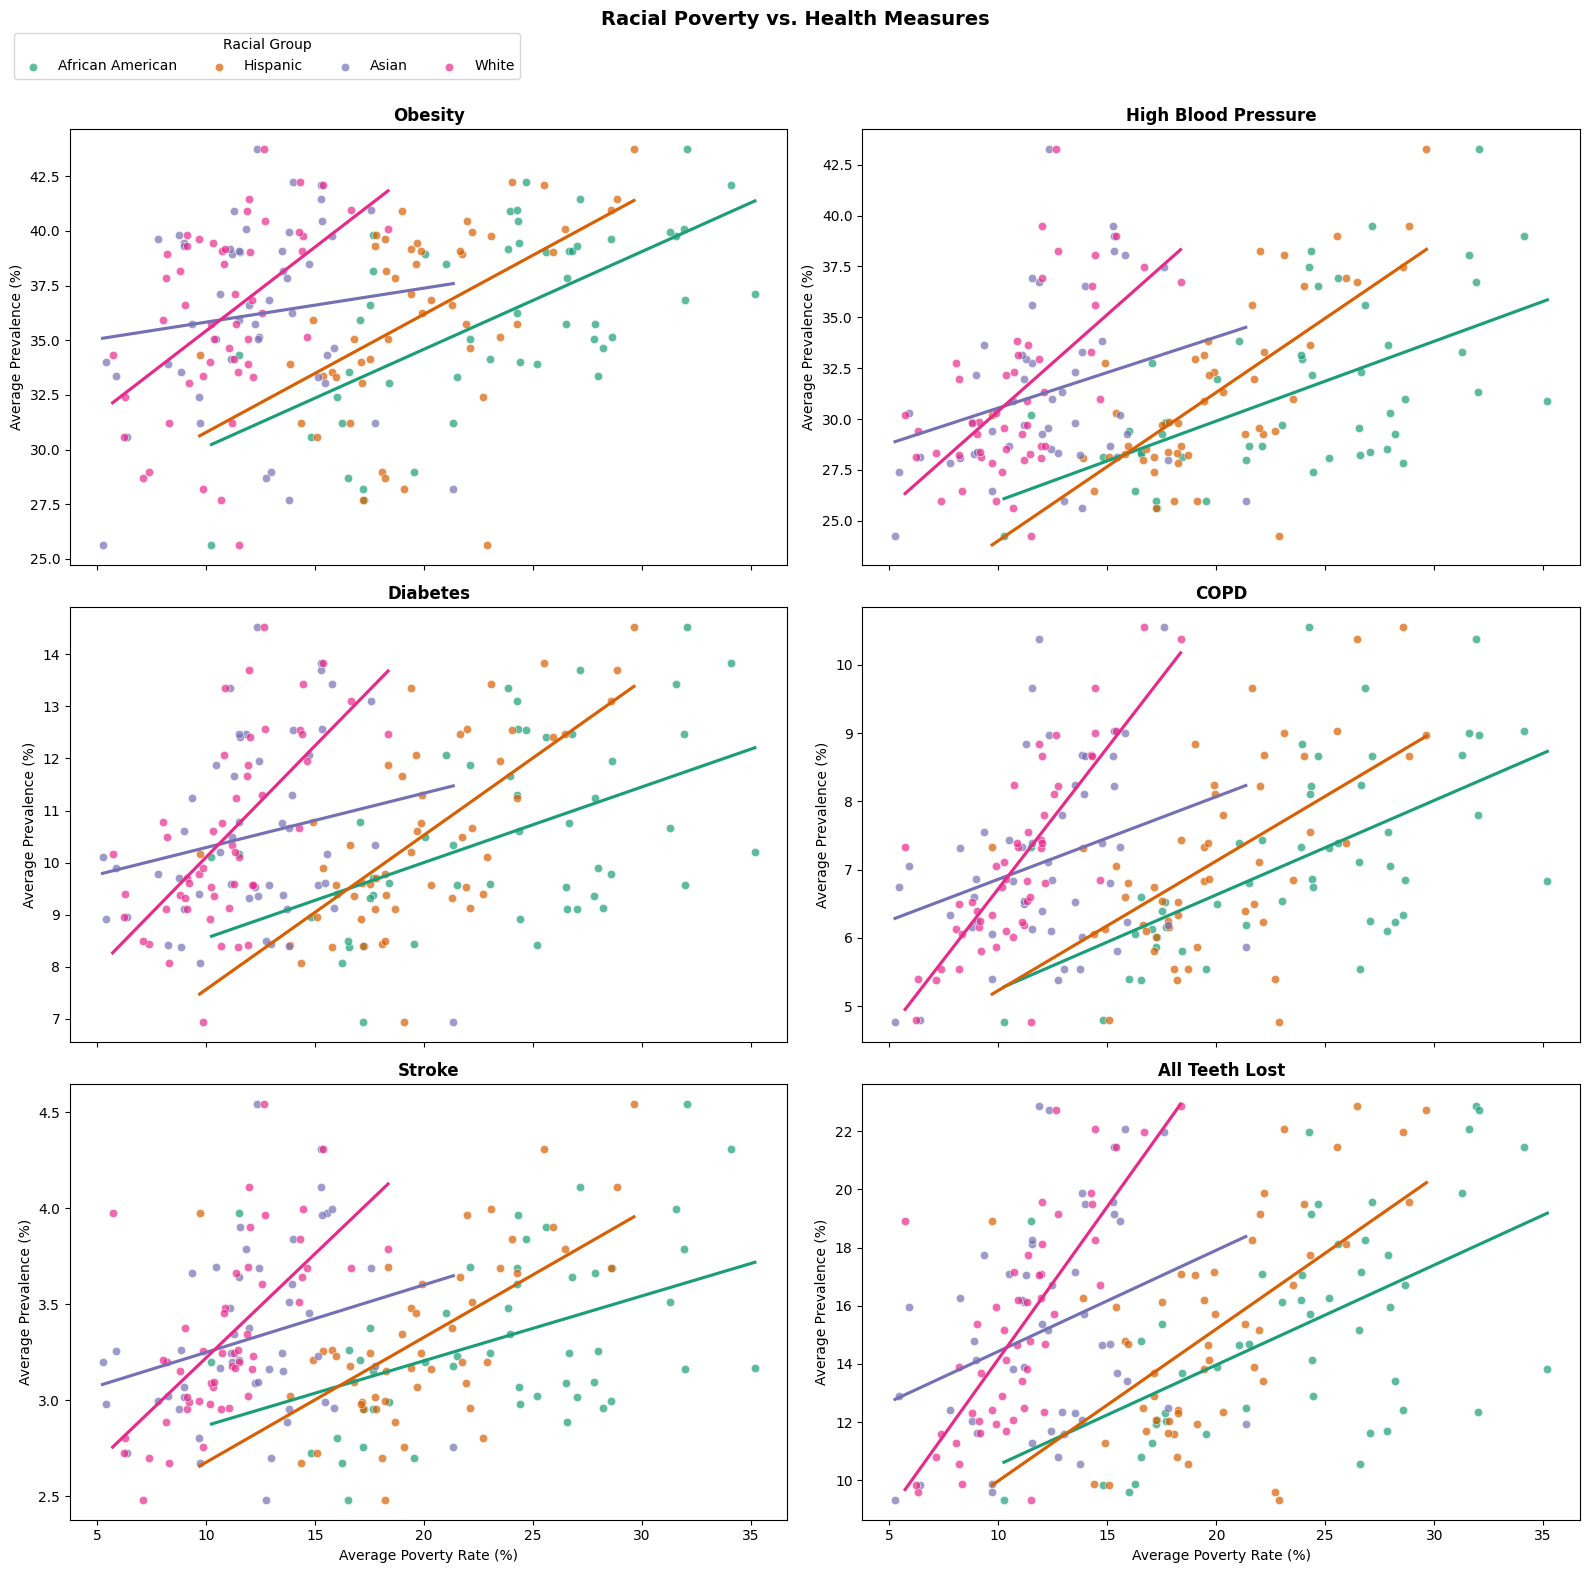

In [44]:
selected_measures = ['Obesity', 'High Blood Pressure', 'Diabetes', 'COPD', 'Stroke', 'All Teeth Lost'] 
# Replacing Cancer with COPD as Cancer metrics are not significant across most poverty groups

# Filter for just the selected measures within Health Outcomes
filtered_df = combined_df_clean[
    (combined_df_clean["Category"] == "Health Outcomes") &
    (combined_df_clean["Health_Measure"].isin(selected_measures))
]


# Pivot so each measure becomes a column with the average prevalence by state
state_health = (
    filtered_df
    .groupby(["State", "Health_Measure"])["Pop_Percent"]
    .mean()
    .reset_index()
    .pivot(index="State", columns="Health_Measure", values="Pop_Percent")
    .reset_index()
)


# Compute state-level average poverty rates for each group
state_poverty = (
    combined_df_clean.groupby("State")
    .agg({
        "BP_ African American%": "mean",
        "BP_ Hispanic or Latino%": "mean",
        "BP_ Asian%": "mean",
        "BP_ White%": "mean",
    })
    .reset_index()
)


# Merge the two dataframes on State
state_analysis = pd.merge(state_poverty, state_health, on="State", how="inner")


melted_list = []
for rg_col, rg_name in [
    ("BP_ African American%", "African American"),
    ("BP_ Hispanic or Latino%", "Hispanic"),
    ("BP_ Asian%", "Asian"),
    ("BP_ White%", "White"),
]:
    # For each racial group, "rg_col" is the column, "rg_name" is the label
    temp = state_analysis[["State"] + selected_measures + [rg_col]].copy()
    temp = temp.melt(
        id_vars=["State", rg_col],
        value_vars=selected_measures,
        var_name="Health_Measure",
        value_name="Prevalence"
    )
    temp["Racial_Group"] = rg_name
    temp.rename(columns={rg_col: "Poverty_Rate"}, inplace=True)
    melted_list.append(temp)

# Concatenate all
facet_data = pd.concat(melted_list, ignore_index=True)


# Create subplots
n_measures = len(selected_measures)
n_cols = 2
n_rows = (n_measures + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16), sharex=True, sharey=False)
axes = axes.flatten()

# Colours for each racial group
unique_groups = facet_data["Racial_Group"].unique()
color_palette = sns.color_palette("Dark2", len(unique_groups))


for i, measure in enumerate(selected_measures):
    ax = axes[i]
    
    # Filter the data for this measure
    measure_df = facet_data[facet_data["Health_Measure"] == measure]
    
    for color, group in zip(color_palette, unique_groups):
        sub_df = measure_df[measure_df["Racial_Group"] == group]
        
        # Scatter plot
        sns.scatterplot(
            data=sub_df,
            x="Poverty_Rate",
            y="Prevalence",
            color=color,
            alpha=0.7,
            ax=ax,
            label=group
        )
        # Regression line
        sns.regplot(
            data=sub_df,
            x="Poverty_Rate",
            y="Prevalence",
            scatter=False,
            color=color,
            ax=ax,
            ci=None
        )
    
    ax.set_title(measure, fontsize=12, fontweight='bold')
    ax.set_xlabel("Average Poverty Rate (%)")
    ax.set_ylabel("Average Prevalence (%)")

# Hide any unused subplot if the grid is bigger than the number of measures
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Get handles and labels from one subplot
handles, labels = axes[0].get_legend_handles_labels()

# Remove local legends from each subplot.
for ax in axes:
    ax.legend([], [], frameon=False)

# Place one legend at the figure level.
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.17, 0.97),
    ncol=len(unique_groups),
    title="Racial Group"
)

# Adjust spacing so the legend doesn't overlap the plots
fig.suptitle("Racial Poverty vs. Health Measures", fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Graphical Setup
- Each subplot focuses on a single **health measure** (e.g., Obesity, Diabetes), with  color-coded points and regression lines for each **racial group**. The slope of each line indicated whether **higher poverty rates** correspond to greater or lower prevalence of that health measure.

### 🔍 **Inference** 

1. **Positive Correlation**:  
   - Across all six health measures (Obesity, High Blood Pressure, Diabetes, COPD, Stroke, and All Teeth Lost), there is a general positive correlation between **Average Poverty Rate (%)** and **Average Prevalence (%)** of the health condition.  
   - This suggests that as poverty rates increase, the prevalence of these health conditions also tends to increase.

2. **Racial Disparities**:  
   - Different racial groups show distinct trends.  
   - African American (green) and Hispanic (orange) groups tend to have higher poverty rates and higher health condition prevalence compared to White (pink) and Asian (purple) groups.  
   - The Asian group (purple) generally shows lower prevalence rates despite varying poverty rates, indicating potential resilience or other socioeconomic factors influencing health outcomes.

3. **Steeper Slopes for Certain Groups**:  
   - The regression lines indicate how strongly poverty rate impacts each racial group.  
   - The White group (pink) often has a steeper slope, meaning small increases in poverty rate correspond to larger increases in health issues.  
   - African Americans and Hispanics also show strong correlations but with varying slopes.

### 2. State-Level Average Racial Poverty Rates (Heatmap) 📊

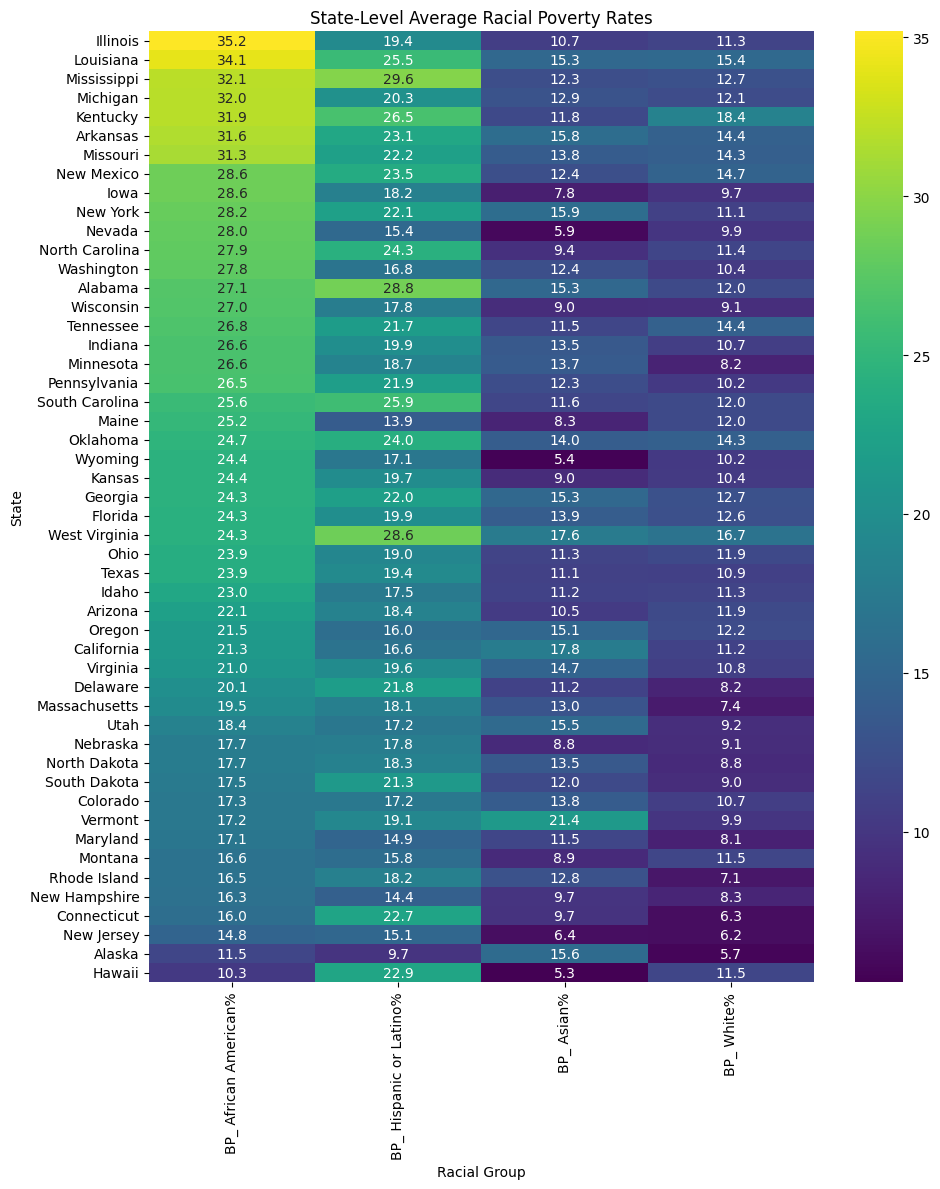

In [45]:
# Compute state-level racial poverty rates for each racial group
state_racial_poverty = state_analysis[["State", "BP_ African American%", "BP_ Hispanic or Latino%", "BP_ Asian%", "BP_ White%"]].copy()
state_racial_poverty.set_index("State", inplace=True)
# Sort the states by African American Poverty Rate in descending order
state_racial_poverty = state_racial_poverty.sort_values(by="BP_ African American%", ascending=False)

plt.figure(figsize=(10, 12))
sns.heatmap(state_racial_poverty, annot=True, cmap="viridis", fmt=".1f")
plt.title("State-Level Average Racial Poverty Rates")
plt.xlabel("Racial Group")
plt.ylabel("State")
plt.tight_layout()
plt.show()

#### Graphical Setup
- Each **row** corresponds to a **U.S. State**, while each **column** is a racial group (African American, Hispanic, Asian).
- A color scale (cool to warm) indicates the magnitude of poverty rates, with higher rates shown in brighter hues.

#### Comparisons
- By examining each **row**, you can quickly see which groups have **relatively higher** or **lower** poverty within the same state.

### 🔍 **Inference**

1. **Racial Disparities in Poverty**:  
   - African Americans and Hispanics consistently have higher poverty rates across most states compared to Asians and Whites.  
   - Asian and White groups generally have lower poverty rates, with a few exceptions where Asians have comparable or higher poverty rates (e.g., Oregon, Utah, Vermont).

2. **Regional Differences**:  
   - Southern and Midwestern states generally have higher poverty rates for all racial groups, but the gap between racial groups is wider.  
   - Western and Northeastern states tend to have lower overall poverty rates, but disparities still exist.

3. **Outliers & Unique Cases**:  
   - Maine and Vermont have relatively low poverty rates but show higher Hispanic or Asian poverty rates compared to their African American or White populations.  

### 3. Racial Poverty vs. Health Outcomes at a State Level (Correlation) 📊

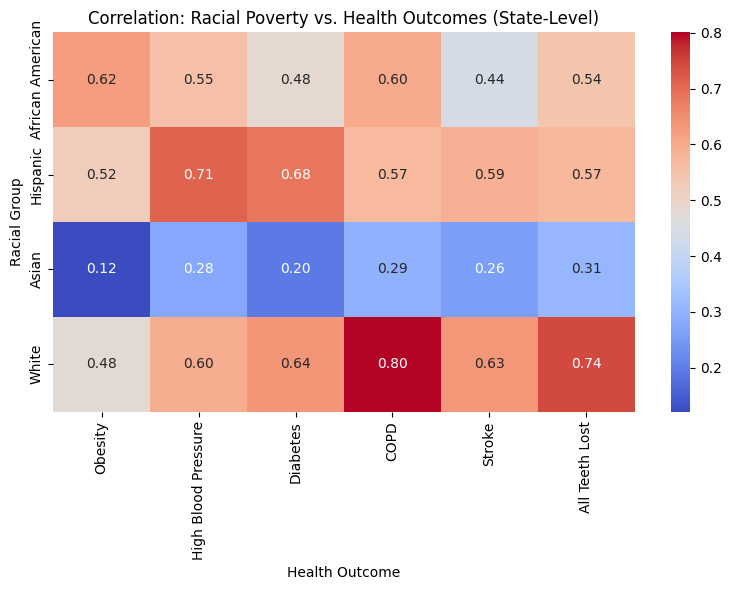

In [46]:
# Filter for selected health outcomes
health_outcomes_state = combined_df_clean[(combined_df_clean["Category"] == "Health Outcomes") & 
                                          (combined_df_clean["Health_Measure"].isin(selected_measures))]

# Compute state-level average health outcome prevalence
state_health = health_outcomes_state.pivot_table(index="State", 
                                                 columns="Health_Measure", 
                                                 values="Pop_Percent", 
                                                 aggfunc="mean").reset_index()
state_health.set_index("State", inplace=True)

# Merge state_health with state_racial_poverty
state_combined = pd.merge(state_racial_poverty, state_health, left_index=True, right_index=True)

# Prepare to compute correlations for each racial group and health outcome
racial_groups = ["BP_ African American%", "BP_ Hispanic or Latino%", "BP_ Asian%", "BP_ White%"]
correlations = pd.DataFrame(index=["African American", "Hispanic", "Asian", "White"], columns=selected_measures)

for rg, rg_name in zip(racial_groups, ["African American", "Hispanic", "Asian", "White"]):
    for outcome in selected_measures:
        correlations.loc[rg_name, outcome] = state_combined[rg].corr(state_combined[outcome])

correlations = correlations.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Racial Poverty vs. Health Outcomes (State-Level)")
plt.xlabel("Health Outcome")
plt.ylabel("Racial Group")
plt.tight_layout()
plt.show()

#### Each cell represents the **linear correlation** between a **racial group’s** poverty rate (rows) and health outcome (columns). Warmer colors represent stronger positive correlations, while cooler colors suggest weaker correlations.

### 🔍 **Inference** 

**Why do Asians have a negative correlation with health outcomes compared to other groups? We can make the following assumptions:**

1. **Healthier Lifestyle & Diet**  
   - Traditional Asian diets are lower in processed foods, unhealthy fats, and sugars, reducing risks for obesity, diabetes, and high blood pressure.  
   - Higher consumption of vegetables, fish, and tea may help prevent chronic diseases, even in lower-income communities.  

2. **Stronger Family & Community Support**   
   - Cultural emphasis on health awareness, home-cooked meals, and traditional medicine may help maintain better health despite economic struggles.  

3. **Higher Use of Preventive Healthcare**  
   - Some Asian populations rely on traditional medicine (herbs, acupuncture) alongside Western healthcare, which may provide additional protection.  

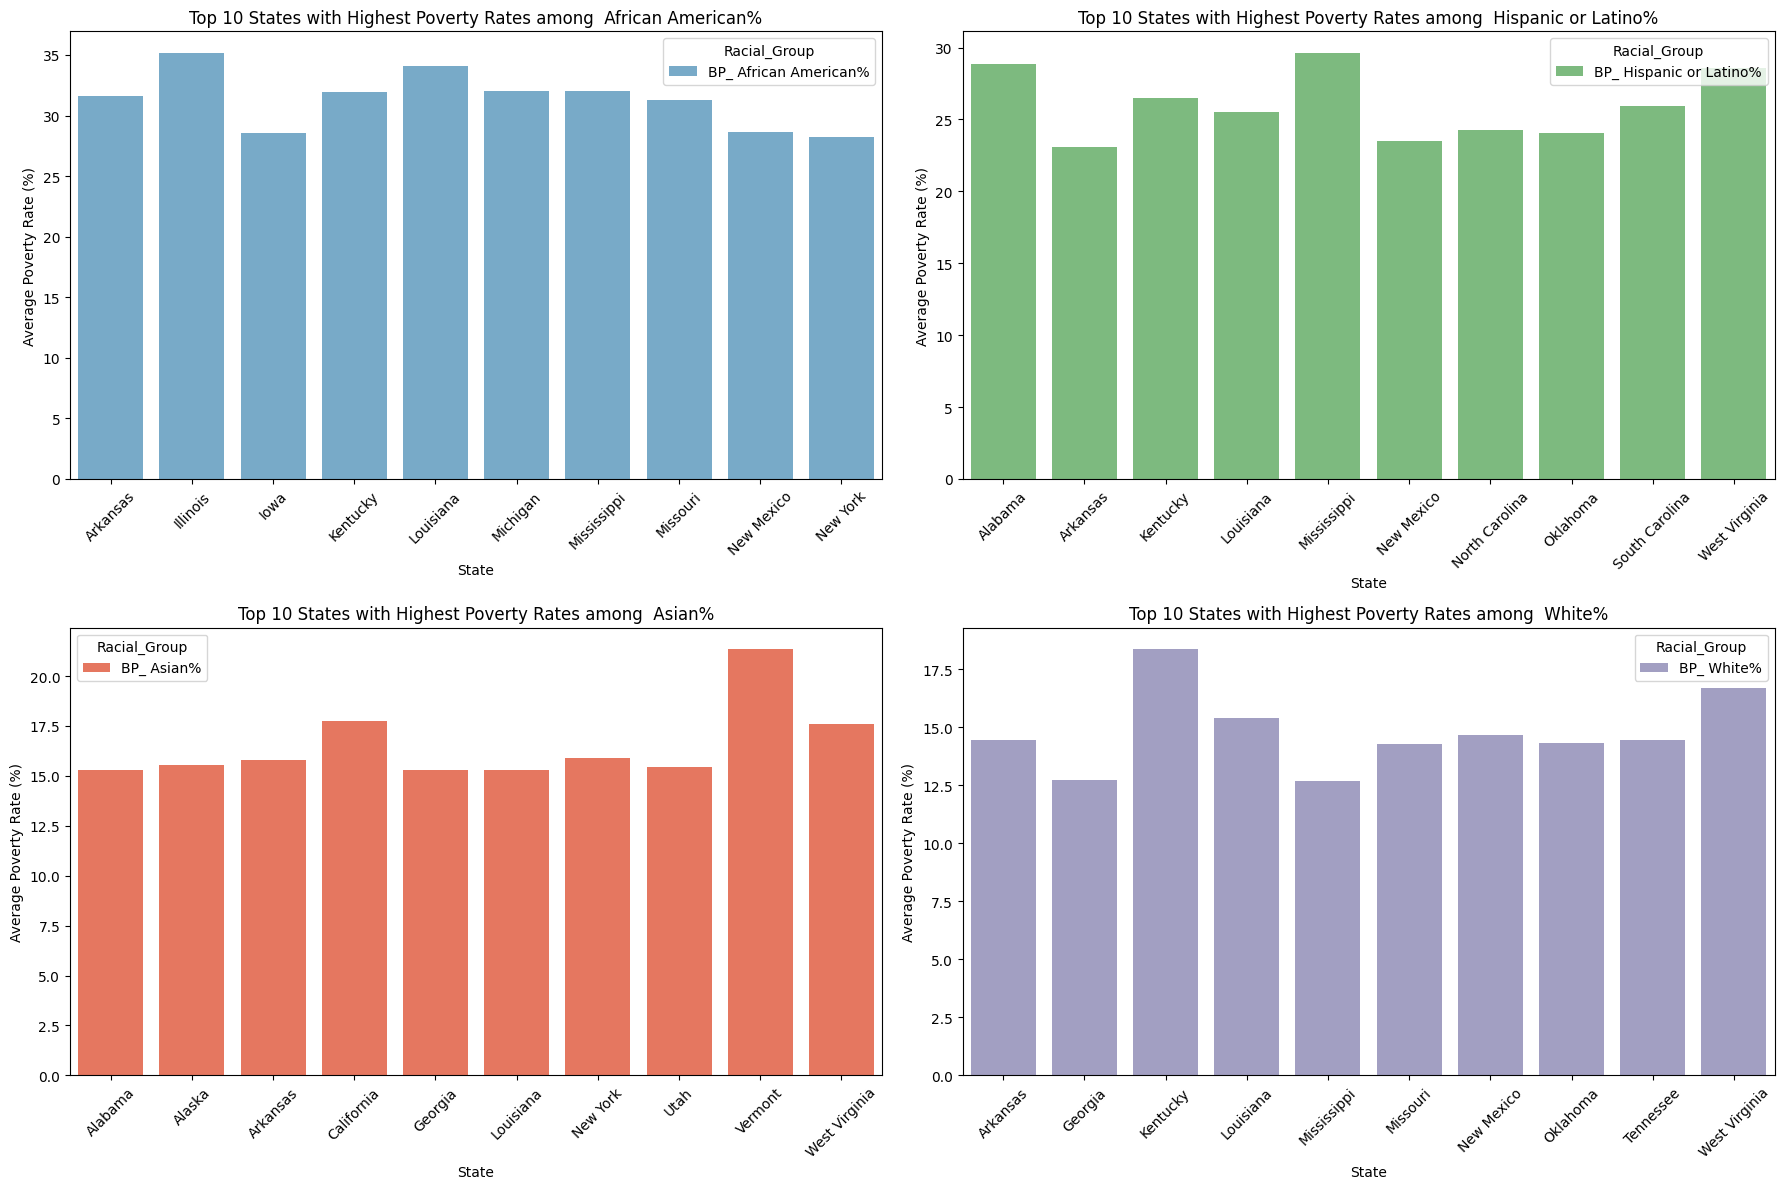

In [47]:
# Melt the dataframe for easier plotting
state_racial_poverty_melted = state_poverty.melt(id_vars="State", var_name="Racial_Group", value_name="Poverty_Rate")

palettes = ["Blues", "Greens", "Reds", "Purples"]

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Loop through the racial groups to create individual plots
for i, (racial_group, palette) in enumerate(zip(racial_groups, palettes)):
    # Calculate the mean poverty rate for each racial group per state
    state_racial_poverty = state_poverty.set_index("State")[racial_group]
    
    # Get the top 10 states with the highest mean poverty rates for the racial group
    top_states = state_racial_poverty.nlargest(10).index
    
    # Filter the data for the selected states and racial group
    filtered_data = state_racial_poverty_melted[
        state_racial_poverty_melted["State"].isin(top_states) & 
        (state_racial_poverty_melted["Racial_Group"] == racial_group)
    ]
    
    # Define the plot position (row, column)
    ax = axes[i // 2, i % 2]
    
    # Plot the barplot with a custom color palette
    sns.barplot(data=filtered_data, x="State", y="Poverty_Rate", hue="Racial_Group", palette=palette, ax=ax)
    ax.set_xlabel("State")
    ax.set_ylabel("Average Poverty Rate (%)")
    ax.set_title(f"Top 10 States with Highest Poverty Rates among {racial_group.split('_')[1]}")
    ax.tick_params(axis="x", rotation=45)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


### 🔍 **Inference**
1. **African American Population**
- States like Illinois, Louisiana, and Mississippi have the highest poverty rates for African Americans, with Illinois recording the highest at 35.19%. 
- Many of these states are located in the South and Midwest, indicating a regional pattern of economic hardship.

2. **Hispanic or Latino Population**:
- The highest poverty rates for this group are found in Mississippi, Alabama, and Kentucky, with Mississippi leading at 29.64%. 
- The affected states are predominantly in the South, suggesting systemic socio-economic challenges affecting Hispanic communities in these areas.

3. **Asian Population:**
- States like California, Vermont, and Arkansas have some of the highest poverty rates for Asians, with Vermont recording the highest at 21.35%.
- California stands out with a relatively high rate of 17.77%, reflecting the large Asian population in the state and highlighting possible economic disparities despite overall higher income levels in some parts of California.
- This indicates that while the poverty rate for the Asian group tends to be relatively lower compared to other racial groups, there are still states, particularly in the West and South, where economic hardship is significant within this community.

4. **White Population**: 
- The highest poverty rates for White individuals are observed in West Virginia, Kentucky, and Arkansas, with West Virginia topping at 16.67%. 
- While the poverty rates are lower compared to minority groups, they remain a concern in economically distressed regions.

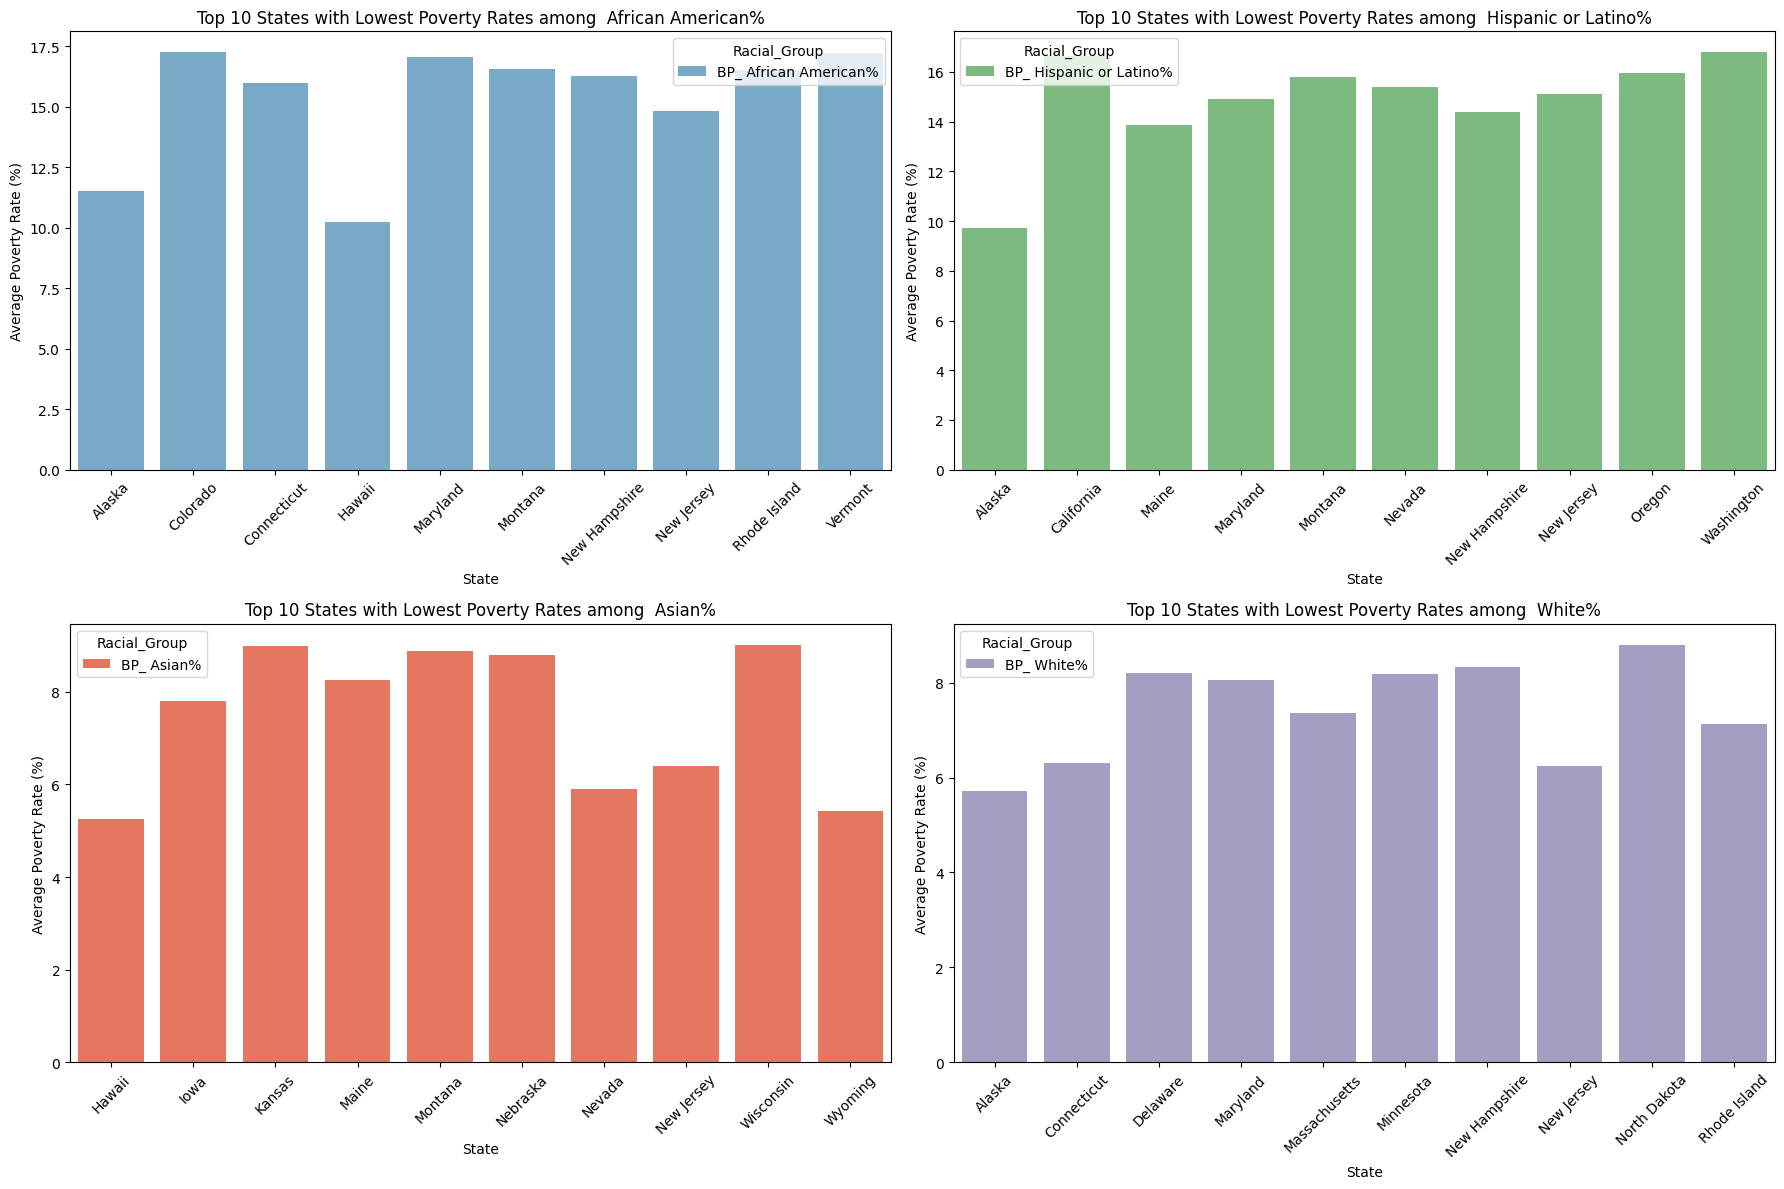

In [48]:
# Melt the dataframe for easier plotting
state_racial_poverty_melted = state_poverty.melt(id_vars="State", var_name="Racial_Group", value_name="Poverty_Rate")

palettes = ["Blues", "Greens", "Reds", "Purples"]

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Loop through the racial groups to create individual plots
for i, (racial_group, palette) in enumerate(zip(racial_groups, palettes)):
    # Calculate the mean poverty rate for each racial group per state
    state_racial_poverty = state_poverty.set_index("State")[racial_group]
    
    # Get the top 10 states with the lowest mean poverty rates for the racial group
    top_states = state_racial_poverty.nsmallest(10).index

    # Filter the data for the selected states and racial group
    filtered_data = state_racial_poverty_melted[
        state_racial_poverty_melted["State"].isin(top_states) & 
        (state_racial_poverty_melted["Racial_Group"] == racial_group)
    ]
    

    # Define the plot position (row, column)
    ax = axes[i // 2, i % 2]
    
    # Plot the barplot with a custom color palette
    sns.barplot(data=filtered_data, x="State", y="Poverty_Rate", hue="Racial_Group", palette=palette, ax=ax)
    ax.set_xlabel("State")
    ax.set_ylabel("Average Poverty Rate (%)")
    ax.set_title(f"Top 10 States with Lowest Poverty Rates among {racial_group.split('_')[1]}")
    ax.tick_params(axis="x", rotation=45)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### 🔍 **Inference**

1. **African American Population**
- States with the lowest poverty rates for African Americans include Hawaii, Alaska, and New Jersey, with Hawaii having the lowest at 10.26%.
- These states are generally known for their higher standards of living and strong economies, which may contribute to lower poverty rates within the African American population.
- Despite these lower poverty rates, some states such as Maryland, Colorado, and Vermont still have higher poverty rates compared to the leading states.

2. **Hispanic or Latino Population**:
- Alaska, Maine, and New Jersey are among the states with the lowest poverty rates for Hispanic or Latino populations, with Alaska having the lowest at 9.72%.
- States like California and Nevada have slightly higher poverty rates in this group, suggesting that while there are lower rates in certain areas, poverty still affects Hispanic communities in states with larger immigrant populations.

3. **Asian Population**
- Hawaii, Wyoming, and Nevada have the lowest poverty rates for Asians, with Hawaii recording the lowest at 5.26%.
- The relatively low poverty rates in states like New Jersey, Iowa, and Montana indicate better economic opportunities for Asians in certain regions, even if the rates are slightly higher in states like Wisconsin and Kansas.

4. **White Population**
- Alaska, New Jersey, and Connecticut have the lowest poverty rates for Whites, with Alaska leading at 5.72%.
- While the poverty rates in these states are quite low, other states like Rhode Island and Minnesota show slightly higher rates, but still reflect relatively stable economic conditions for White populations in these regions.

## 📖 Synthesis
### Question 3: How do poverty rates correlate with health disparities among people of color across different states?

#### The correlation between poverty rates and health disparities among racial and ethnic minorities across different states is a well-documented phenomenon in public health research. The relationship between economic hardship and poor health outcomes extends beyond mere income levels-- incorporating systemic, structural, and geographic factors.

### **The Economic Burden and Health Outcomes**
#### African American and Hispanic/Latino Populations

#### African Americans and Hispanic/Latino populations experience disproportionately high poverty rates, which directly correlate with adverse health outcomes. For instance, Illinois exhibits one of the highest African American poverty rates (35.19%), which coincides with an increased prevalence of chronic diseases, including arthritis, COPD, diabetes, and obesity. This pattern aligns with studies indicating that economic hardship contributes to limited healthcare access, increased stress, and higher disease susceptibility (Williams & Mohammed, 2013). Similarly, Hispanic populations in Mississippi face heightened health disparities due to structural inequities in healthcare access and employment opportunities (Flores et al., 2017).

#### The Role of Structural and Regional Factors

#### While economic status remains a significant determinant, geographic disparities in healthcare infrastructure exacerbate health inequities. The stark contrast between Illinois and Hawaii highlights how regional healthcare access influences disease prevalence. Illinois, with higher poverty rates among African Americans, reports a significantly higher prevalence of depression (22.64%) compared to Hawaii (16.46%), suggesting that economic stress exacerbates mental health conditions. However, similar stroke rates across both states (Illinois: 3.17%, Hawaii: 3.20%) suggest that genetic predispositions or healthcare interventions may mediate certain health outcomes independent of economic status (Braveman et al., 2011).

#### Mental Health and Geographic Isolation
#### Vermont and Kentucky provide further insights into the relationship between poverty and mental health. Despite its lower poverty rates, Vermont exhibits the highest depression rates (26.97%), suggesting that factors such as geographic isolation, limited mental healthcare services, and social determinants of health contribute to poor mental well-being (Probst et al., 2018). Similarly, Kentucky’s high rates of arthritis, COPD, and obesity suggest a compounded effect of economic and lifestyle factors on physical and mental health outcomes. These findings underscore the need for mental health interventions that account for both economic and geographic determinants.

### **Health Disparities Beyond Income Levels**

#### Oral Health as an Indicator of Economic Inequality
#### Oral health disparities serve as a tangible marker of broader economic and healthcare access issues. In Illinois, the tooth loss rate (13.83%) exceeds that of Hawaii (9.32%), aligning with research indicating that lower-income individuals are more likely to forgo preventive dental care, leading to long-term health consequences (Griffin et al., 2012). The absence of adequate dental insurance coverage further exacerbates these disparities, reinforcing the broader connection between economic hardship and health.

### The Role of Genetics and Dietary Patterns
#### While poverty is a key determinant of health disparities, certain findings challenge a direct correlation. For example, despite lower poverty rates, Hawaii has higher diabetes rates (10.10%), suggesting that genetic predispositions and dietary habits among Pacific Islander populations contribute to disease prevalence (Nguyen & El-Serag, 2010). Similarly, stroke and cancer rates do not always align with poverty levels, emphasizing the influence of biological and environmental factors beyond economic status.

### **Racial and Regional Disparities**

#### Asian Communities in Rural States
#### Findings from Vermont suggest that economic disparities among Asian populations in rural states can have a pronounced effect on health. While Asians generally exhibit better health indicators nationwide, research indicates that certain subgroups, such as Southeast Asians, experience higher poverty rates than aggregated statistics suggest (Islam et al., 2010). Limited healthcare access and employment opportunities in states with smaller Asian populations may intensify these disparities.

#### The Impact of White Poverty in Appalachia and Alaska
#### The strong correlation between white poverty and poor health outcomes in Kentucky reflects the economic struggles of Appalachia, where chronic health conditions like opioid addiction, heart disease, and diabetes are prevalent (Case & Deaton, 2017). Similarly, in Alaska, poverty-related health disparities among white populations are influenced by rural healthcare access issues, high medical costs, and extreme climate conditions, reinforcing that poverty-driven health disparities affect all racial groups.

### **Policy Implications and Interventions**
####  The findings underscore that poverty-driven health disparities are not solely a function of race but are shaped by economic, social, and systemic factors. Addressing these disparities requires a multi-faceted approach, including healthcare reform which could include expanding Medicaid and improving access to affordable healthcare can mitigate disparities (Bailey et al., 2017). Addressing employment inequalities and raising wages for low-income populations can also reduce health disparities (Chetty et al., 2016). Localized efforts, such as culturally competent healthcare services and targeted outreach programs, are crucial for improving health outcomes in disadvantaged communities.

#### The relationship between poverty and health disparities among racial and ethnic minorities is complex and multifaceted. While economic hardship remains a strong predictor of poor health outcomes, structural inequities, geographic factors, and biological predispositions play crucial roles in shaping these disparities. Addressing these issues requires comprehensive policy interventions that integrate healthcare reform, economic improvements, and community-based solutions.

**References**

- Bailey, Z. D., Krieger, N., Agénor, M., Graves, J., Linos, N., & Bassett, M. T. (2017). Structural racism and health inequities in the USA: Evidence and interventions. *The Lancet, 389*(10077), 1453-1463.
- Braveman, P., Egerter, S., & Williams, D. R. (2011). The social determinants of health: Coming of age. *Annual Review of Public Health, 32*, 381-398.
- Case, A., & Deaton, A. (2017). Mortality and morbidity in the 21st century. *Brookings Papers on Economic Activity, 2017*(1), 397-476.
- Chetty, R., Stepner, M., Abraham, S., Lin, S., Scuderi, B., Turner, N., ... & Cutler, D. (2016). The association between income and life expectancy in the United States, 2001-2014. *JAMA, 315*(16), 1750-1766.
- Flores, Y. G., Talamantes, M. A., Salinas, C. F., & Bastani, R. (2017). Perspectives on healthy aging among Mexican-origin elders. *Journal of Cross-Cultural Gerontology, 32*(2), 125-140.
- Griffin, S. O., Jones, J. A., Brunson, D., Griffin, P. M., & Bailey, W. D. (2012). Burden of oral disease among older adults and implications for public health priorities. *American Journal of Public Health, 102*(3), 411-418.
- Islam, N. S., Kwon, S. C., Wyatt, L. C., Ruddock, C., & Trinh-Shevrin, C. (2010). Disparities in diabetes management in Asian Americans in New York City compared with other racial/ethnic minority groups. *American Journal of Public Health, 100*(S2), S389-S397.
- Nguyen, G. C., & El-Serag, H. B. (2010). The epidemiology of obesity. *Gastroenterology Clinics, 39*(1), 1-7.
- Probst, J. C., Laditka, S. B., Moore, C. G., Harun, N., & Powell, M. P. (2018). Depression in rural populations: Prevalence, effects, and disparities. *Journal of Rural Health, 34*(1), 54-62.
- Williams, D. R., & Mohammed, S. A. (2013). Racism and health I: Pathways and scientific evidence. *American Behavioral Scientist, 57*(8), 1152-1173.

## 🧩 Why Combine Socioeconomic and Health Data?

Integrating CDC PLACES health indicators with Census socioeconomic data allows for a more holistic understanding of how poverty influences health outcomes. The geographic component reveals disparities across states and counties, highlighting how local policies and healthcare access affect public health. The socioeconomic dimension provides deeper insights into why certain health conditions are more prevalent in specific regions, reinforcing the link between poverty and health outcomes.

### How Does the Relationship Between Poverty Rates and Health Outcomes Vary Across U.S. Counties?

By integrating socioeconomic and health data, we can analyze how poverty rates impact health outcomes at the county level. This approach helps identify whether high-poverty areas experience significantly worse health outcomes compared to wealthier counties. The geographic perspective provides insights into regional disparities, while socioeconomic indicators help explain underlying factors such as healthcare access, environmental stressors, and policy differences.

### What Health Risk Behaviors Are Most Prevalent in Counties with Higher Poverty Rates?

Combining health and socioeconomic data allows for an in-depth analysis of how behavioral risk factors—such as smoking, poor nutrition, and physical inactivity—are linked to poverty. Understanding these patterns helps assess whether these behaviors correlate with disease prevalence in low-income communities. This integrated approach highlights the social determinants of health and informs targeted public health interventions.

### How Do Poverty Rates Correlate with Health Disparities Among People of Color Across Different States?

By examining poverty and health data together, we can better understand how economic disadvantage disproportionately affects health outcomes among people of color. This analysis reveals systemic disparities across states, influenced by historical inequities, policy decisions, and differences in healthcare access. Identifying these correlations helps address racial health inequities through data-driven policy and resource allocation.


## 💭 Reflection

1. **Challenges Encountered:**
- Data Integration: Merging datasets with different geographical identifiers required careful cleaning and alignment.
- Handling Missing Data: Some counties lacked health indicators, requiring either imputation or exclusion from analysis.
- Interpreting Correlation vs. Causation: While strong correlations were observed, causality cannot be confirmed without more controlled studies.

2. **Limitations of the Analysis:**
- Self-Reported Bias: CDC PLACES data is based on self-reported surveys, which may not always be accurate.
- Aggregated Data Issues: County-level aggregation masks within-region disparities, making it hard to pinpoint localized differences.
- Lack of Longitudinal Perspective: The data represents a single time snapshot, preventing us from analyzing long-term trends

3. **Future Research Directions:**
- Longitudinal Analysis: Examining multi-year trends to track how health outcomes evolve with economic shifts.
- Policy Impact Evaluation: Studying how state-level health policies (e.g., Medicaid expansion) impact chronic disease prevalence in low-income areas.

## Declaration of Gen AI 🤖:
#### We have used generative AI for:
- Markdown beautification in the introduction.
- Editing our code comments to make them more professional in appearance
- Research and editing the references section for our synthesis